# Load in counts table & name samples

In [260]:
a<-read.csv('SamplesViewReportCLIO_AE1913merged_trans210506_updated220606exclusive.csv',header=T, stringsAsFactors=F) #exclusive spectral counts

In [261]:
rownames(a)<-a$Name #for TPM_table.tab and table.tab and exclusive counts
a<-a[,-1]

In [262]:
a <- a[,colSums(is.na(a))<nrow(a)] #Remove added columns with empty values
a[is.na(a)] <- 0 #for proteins

In [263]:
#Remove X from colnames
colnames(a)<-sub("X", "", colnames(a))

In [264]:
cts1<-a

In [265]:
library(dplyr)

In [266]:
cts1$X<-rownames(cts1)

# spectral count normalization

In [267]:
length<-read.table('cds.length2.tab',header=F,sep=' ',stringsAsFactors=F) #ORF length in bp

In [268]:
colnames(length)<-c('X','length')

In [269]:
join<-merge(length, cts1, by='X',all=F) #join with ORF length

In [270]:
head(join)

X                            length 1_30_0.2 1_115_0.2 1_30_3 1_115_3 1_150
1 megahit_HN001_k141_100053.p1 1833   0        0         0      0       0    
2 megahit_HN001_k141_100230.p1  546   0        0         0      0       0    
3 megahit_HN001_k141_10061.p1   477   2        0         0      0       0    
4 megahit_HN001_k141_100671.p1  543   1        0         0      0       0    
5 megahit_HN001_k141_101601.p1  660   0        0         0      0       0    
6 megahit_HN001_k141_101642.p1  537   5        2         0      0       0    
  1_200 1_300 1_400 ⋯ 7_150 7_300 8_20 8_40 8_120 8_175 8_400 8_800 8_250 8_600
1 0     0     0     ⋯ 0     0     0    0    0     0     0     0     0     0    
2 0     0     0     ⋯ 0     0     0    0    0     0     0     0     0     0    
3 0     0     0     ⋯ 0     0     0    0    0     0     0     0     0     0    
4 0     0     0     ⋯ 0     0     0    0    0     0     0     0     0     0    
5 0     0     0     ⋯ 0     0     0    0    0     0     0     0     0     0    
6 0     0     0     ⋯ 0     0     0    0    0     0     0     0     0     0

In [271]:
#NSAF normalized counts
join[is.na(join)] <- 0
join[,3:88]<-lapply(join[,3:88],as.numeric)
x <- join[3:88] / (join$length/3) #convert nucleotide bp to AA bp
nsaf <- t( t(x) * 1e3 / colSums(x) )
nsaf1<-as.data.frame(nsaf)
nsaf1$transcript_name<-join$X
cts1<-nsaf1

In [227]:
options(repr.matrix.max.cols=80, repr.matrix.max.rows=80)

# Load in annotation table 

In [418]:
library(caroline)
tax<-read.tab('newtaxa.eukprot.merged.fasta.transdecoder-estimated-taxonomy.out') 

aa<-tax[order(tax$transcript_name, (tax$max_pid)), ] 
bb<-aa[ !duplicated(aa$transcript_name), ] #Remove duplicates

tax<-bb

rownames(tax)<-tax$transcript_name

library(stringr)
library(tidyr)
tax<- tax %>%
  separate(full_classification, c("domain","supergroup", "division","class","order","family","genus","species"), ";")

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 7329870 rows [1, 2, 3, 4,
5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [419]:
merge<-merge(cts1, tax, by='transcript_name') 
rownames(merge)<-merge$transcript_name

In [420]:
# For kegg KOs
egg<-read.delim('eggnog.emapper.annotations',sep="\t",header=F)
egg<-egg[-1,]
egg<-egg[-1,]
egg<-egg[-1,]
egg<-egg[-1,]
colnames(egg)<-c('transcript_name','seed_ortholog','evalue','score','eggNOG_OG', 'narr_OG_name', 'narrOG_cat','narr_OG_desc','best_OG_names','best_OG_cat','best_OG_desc','Preferred_name','GOs','EC','KEGG_ko','KAGG_pathway','KEGG_Module','KEGG_Reaction','KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG_Reaction','PFAMs')
egg<-egg[-1,]
#head(egg)
sub<-merge(egg, merge, by='transcript_name')
subset<-subset(sub, select = c('transcript_name','class','KEGG_ko','domain','division'))
subset[,6:92]<-sub[,25:111]

library(caroline)
key<-read.tab('rest.kegg.jp.txt')
colnames(key)<-c('KEGG_ko','def')
test<-subset #subset=file with taxonomy (class),KEGG_ko, counts, see below heatmap section
test1<-test[!grepl('-',test$KEGG_ko),] #Get rid of rows with KEGG_kos  "-" 
subset<-test1
library(tidyr)
library(dplyr)
subset1<-subset %>% 
    mutate(KEGG_ko = strsplit(as.character(KEGG_ko), ",")) %>% 
    unnest(KEGG_ko) #Send counts to all KOs listed

In [567]:
#Testing splitting counts among KOs
split_and_divide <- function(df) {
  df %>%
    mutate(KEGG_ko=str_split(KEGG_ko, ",")) %>%
    rowwise() %>% 
    mutate_at((6:91), funs(. / length(unlist(KEGG_ko)))) %>%
    unnest(KEGG_ko)  
}

subset1 <- split_and_divide(subset)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [568]:
#Subset euks
x<-subset1
euk<-c('Eukaryota')
x<-x[x$domain %in% euk,]

In [ ]:
#For network, leave division and KO columns in the table, remove everything else
x<-x[,-1]
x<-x[,-1]
x<-x[,-2]
x<-x[,-89]
head(x)

In [569]:
#For PLS, remove division column
x<-x[,-1]
x<-x[,-1]
x<-x[,-2]
x<-x[,-89]
x<-x[,-2]
head(x)

KEGG_ko   1_30_0.2   1_115_0.2 1_30_3      1_115_3 1_150 1_200 1_300 1_400
1 ko:K02875 0.00000000 0         0.000000000 0       0     0     0     0    
2 ko:K01412 0.00000000 0         0.000000000 0       0     0     0     0    
3 ko:K13811 0.00000000 0         0.000000000 0       0     0     0     0    
4 ko:K00860 0.00334165 0         0.008916284 0       0     0     0     0    
5 ko:K00958 0.00334165 0         0.008916284 0       0     0     0     0    
6 ko:K01507 0.00334165 0         0.008916284 0       0     0     0     0    
  1_600 ⋯ 7_150 7_300 8_20       8_40 8_120 8_175 8_400 8_800 8_250 8_600
1 0     ⋯ 0     0     0.00000000 0    0     0     0     0     0     0    
2 0     ⋯ 0     0     0.00000000 0    0     0     0     0     0     0    
3 0     ⋯ 0     0     0.00000000 0    0     0     0     0     0     0    
4 0     ⋯ 0     0     0.00546418 0    0     0     0     0     0     0    
5 0     ⋯ 0     0     0.00546418 0    0     0     0     0     0     0    
6 0     ⋯ 0     0     0.00546418 0    0     0     0     0     0     0

In [463]:
# Sum by euk division and KO for network, just by KO for PLS
#library(dplyr)
d <- x %>%
    group_by(division,KEGG_ko) %>% summarise_all(funs(sum))

d$ID<-paste(d$division, d$KEGG_ko, sep='_')

d<-as.data.frame(d)
rownames(d)<-d$ID

head(d)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


division         KEGG_ko   1_30_0.2   1_115_0.2
 Ancyromonadidae_ko:K00364  Ancyromonadidae ko:K00364 0.00000000 0        
 Apicomplexa_ko:K00024      Apicomplexa     ko:K00024 0.00000000 0        
 Apicomplexa_ko:K00025      Apicomplexa     ko:K00025 0.00000000 0        
 Apicomplexa_ko:K00026      Apicomplexa     ko:K00026 0.00000000 0        
 Apicomplexa_ko:K00134      Apicomplexa     ko:K00134 0.02041099 0        
 Apicomplexa_ko:K00600      Apicomplexa     ko:K00600 0.00000000 0        
                           1_30_3     1_115_3    1_150 1_200 1_300 1_400 ⋯
 Ancyromonadidae_ko:K00364 0.00000000 0.00000000 0     0     0     0     ⋯
 Apicomplexa_ko:K00024     0.00000000 0.00000000 0     0     0     0     ⋯
 Apicomplexa_ko:K00025     0.00000000 0.00000000 0     0     0     0     ⋯
 Apicomplexa_ko:K00026     0.00000000 0.00000000 0     0     0     0     ⋯
 Apicomplexa_ko:K00134     0.05309965 0.01557798 0     0     0     0     ⋯
 Apicomplexa_ko:K00600     0.00000000 0.00000000 0     0     0     0     ⋯
                           7_300 8_20      8_40       8_120 8_175 8_400 8_800
 Ancyromonadidae_ko:K00364 0     0.0000000 0.00000000 0     0     0     0    
 Apicomplexa_ko:K00024     0     0.0000000 0.00000000 0     0     0     0    
 Apicomplexa_ko:K00025     0     0.0000000 0.00000000 0     0     0     0    
 Apicomplexa_ko:K00026     0     0.0000000 0.00000000 0     0     0     0    
 Apicomplexa_ko:K00134     0     0.1318334 0.07384095 0     0     0     0    
 Apicomplexa_ko:K00600     0     0.0000000 0.00000000 0     0     0     0    
                           8_250 8_600 ID                        
 Ancyromonadidae_ko:K00364 0     0      Ancyromonadidae_ko:K00364
 Apicomplexa_ko:K00024     0     0      Apicomplexa_ko:K00024    
 Apicomplexa_ko:K00025     0     0      Apicomplexa_ko:K00025    
 Apicomplexa_ko:K00026     0     0      Apicomplexa_ko:K00026    
 Apicomplexa_ko:K00134     0     0      Apicomplexa_ko:K00134    
 Apicomplexa_ko:K00600     0     0      Apicomplexa_ko:K00600

In [464]:
d<-d[,-89]
d<-d[,-1]
d<-d[,-1]

# network analysis with igraph

In [465]:
keep<-d[rowSums(d) > 0.01, colSums(d) > 0]

In [466]:
nrow(keep)

[1] 3398

In [467]:
o<-log2(keep+1)

In [468]:
d<-o

In [469]:
nrow(d)

[1] 3398

In [470]:
library(igraph)

In [471]:
#adapted from https://www.biostars.org/p/285296/
g <- graph.adjacency(
  as.matrix(as.dist(cor(t(d), method="spearman"))),
  mode="undirected",
  weighted=TRUE,
  diag=FALSE
)

In [472]:
g

IGRAPH 3963800 UNW- 3398 5771488 -- 
+ attr: name (v/c), weight (e/n)
+ edges from 3963800 (vertex names):
 [1]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K00134
 [2]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K01803
 [3]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K02115
 [4]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K02966
 [5]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K03231
 [6]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K08341
 [7]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K12388
 [8]  Ancyromonadidae_ko:K00364-- Apicomplexa_ko:K12589
+ ... omitted several edges

In [473]:
g <- simplify(g, remove.multiple=TRUE, remove.loops=TRUE)

# Colour negative correlation edges as blue
E(g)[which(E(g)$weight<0)]$color <- "#000000"

# Colour positive correlation edges as red
E(g)[which(E(g)$weight>0)]$color <- "#ed1162"




In [474]:
# Convert edge weights to absolute values
E(g)$weight <- abs(E(g)$weight)
g <- delete_edges(g, E(g)[which(E(g)$weight<0.65)])

# Remove any vertices remaining that have no edges
g <- delete.vertices(g, degree(g)==0)

In [475]:
# Change colour of vertex frames
V(g)$vertex.frame.color <- "black"

# Amplify or decrease the width of the edges
edgeweights <- E(g)$weight * 10.0

# Convert the graph adjacency object into a minimum spanning tree based on Prim's algorithm
mst <- mst(g, algorithm="prim")
#mst <- g

In [476]:
library(stringr)

In [477]:
mst.nodes <- as.data.frame(vertex.attributes(g), stringsAsFactors=FALSE)
mst.nodes$taxa<-str_extract(mst.nodes$name, "([^_]*)")
mst.nodes$ko<-str_extract(mst.nodes$name, "(_.*)")
mst.nodes$ko<-str_remove_all(mst.nodes$ko,"_")
mst.nodes$ko<-gsub("X","",as.character(mst.nodes$ko))
cols <- c(' Chlorophyta'='#80ff80', ' Ciliophora'='#c44dff', ' Collodictyonidae'='#ccccff', ' Cryptophyta'='#cc0044', ' Dinophyta'='#0052cc', ' Discoba'='#ffd9b3',' Foraminifera'='#669999',' Fungi'='#FFE6FF',' Haptophyta'='#FFE74A', ' Lobosa'='#000000',' Marine_stramenopiles_MASTs group'='#9c7b11',' Metazoa'='#1affff',' Picozoa'='#fc8123',' Radiolaria'='#942649',' Stramenopiles'='#ff9999',' Ancyromonadidae'='#dddddd', ' Apicomplexa'='#dddddd',' Centroplasthelida'='#dddddd',' Cercozoa'='#dddddd',' Choanoflagellata'='#dddddd',' Choanoflagellida'='#dddddd',' Colpodellida'='#dddddd',' Colponemidia'='#dddddd',' Corallochytrium'='#dddddd',' Endomyxa'='#dddddd',' Evosea'='#dddddd',' Filasterea'='#dddddd',' Glaucocystophyta'='#dddddd',' Ichthyosporea'='#dddddd',' Loukozoa'='#dddddd',' Mantamonadidae'='#dddddd',' Marine'='#dddddd',' Oomycota'='#dddddd',' Perkinsea'='#dddddd',' Prasinodermophyta'='#dddddd',' Rhodelphida'='#dddddd',' Rhodophyta'='#dddddd',' Squirmida'='#dddddd',' Streptophyta'='#dddddd',' Telonemia'='#dddddd',' Tubulinea'='#dddddd')

V(mst)$color<-cols[as.character(mst.nodes$taxa)]

In [478]:
unique(mst.nodes$taxa)

[1] " Ancyromonadidae"   " Apicomplexa"       " Centroplasthelida"
 [4] " Cercozoa"          " Chlorophyta"       " Choanoflagellata" 
 [7] " Choanoflagellida"  " Ciliophora"        " Collodictyonidae" 
[10] " Colpodellida"      " Colponemidia"      " Corallochytrium"  
[13] " Cryptophyta"       " Dinophyta"         " Discoba"          
[16] " Endomyxa"          " Evosea"            " Filasterea"       
[19] " Foraminifera"      " Fungi"             " Glaucocystophyta" 
[22] " Haptophyta"        " Ichthyosporea"     " Lobosa"           
[25] " Loukozoa"          " Mantamonadidae"    " Marine"           
[28] " Metazoa"           " Oomycota"          " Perkinsea"        
[31] " Picozoa"           " Prasinodermophyta" " Radiolaria"       
[34] " Rhodelphida"       " Rhodophyta"        " Squirmida"        
[37] " Stramenopiles"     " Streptophyta"      " Telonemia"        
[40] " Tubulinea"         "NA"

In [479]:
edgeweights <- E(g)$weight * 2

In [480]:
#https://stackoverflow.com/questions/58543917/in-igraph-in-r-is-it-possible-to-create-dotted-lines-around-the-vertex-objects

myimg <- function(coords, v=NULL, params) {
  vertex.color <- params("vertex", "color")
  if (length(vertex.color) != 1 && !is.null(v)) {
    vertex.color <- vertex.color[v]
  }
  vertex.size  <- 1/200 * params("vertex", "size")
  if (length(vertex.size) != 1 && !is.null(v)) {
    vertex.size <- vertex.size[v]
  }
  vertex.frame.color <- params("vertex", "frame.color")
  if (length(vertex.frame.color) != 1 && !is.null(v)) {
    vertex.frame.color <- vertex.frame.color[v]
  }
  vertex.frame.width <- params("vertex", "frame.width")
  if (length(vertex.frame.width) != 1 && !is.null(v)) {
    vertex.frame.width <- vertex.frame.width[v]
  }
  ltype <- params("vertex", "ltype")
  if (length(ltype) != 1 && !is.null(v)) {
    ltype <- ltype[v]
  }   

  mapply(coords[,1], coords[,2], vertex.color, vertex.frame.color,
         vertex.size, vertex.frame.width, ltype, 
         FUN=function(x, y, bg, fg, size, lwd, lty) {
           symbols(x=x, y=y, bg=bg, fg=fg, lwd=lwd, lty=lty,
                   circles=size, add=TRUE, inches=FALSE)
         })
  }

In [481]:
add_shape("myimg",  plot=myimg, 
          parameters = list(
            vertex.frame.color=1, 
            vertex.frame.width=1,
            vertex.ltype=1))

In [482]:
ko<-read.table('rest.kegg.jp.txt',header=F,stringsAsFactor=F,sep="\t",quote="")
colnames(ko)<-c('ko','def')
test<-merge(mst.nodes, ko, by='ko',all=T)
test1<-test[!is.na(test$name), ]
mst.nodes<-test1

In [483]:
#Remove secondary subnetworks, keep main one
main <- induced_subgraph(
  mst, V(mst)[components(mst)$membership == which.max(components(mst)$csize)]
)

In [484]:
main

IGRAPH dcc34ed UNW- 2938 2937 -- 
+ attr: name (v/c), vertex.frame.color (v/c), color (v/c), weight
| (e/n), color (e/c)
+ edges from dcc34ed (vertex names):
 [1]  Ancyromonadidae_ko:K00364-- Rhodophyta_ko:K06630 
 [2]  Ancyromonadidae_ko:K00364--NA_ko:K11098          
 [3]  Apicomplexa_ko:K00134    --NA_ko:K08965          
 [4]  Apicomplexa_ko:K01803    --NA_ko:K08965          
 [5]  Apicomplexa_ko:K02115    -- Cryptophyta_ko:K02112
 [6]  Apicomplexa_ko:K02115    -- Cryptophyta_ko:K02114
 [7]  Apicomplexa_ko:K02115    --NA_ko:K08901          
+ ... omitted several edges

In [485]:
#Optional clustering
#main.communities <- edge.betweenness.community(main, weights=NULL, directed=FALSE)
#main.clustering <- make_clusters(main, membership=main.communities$membership)

In [486]:
mst.nodes <- as.data.frame(vertex.attributes(main), stringsAsFactors=FALSE)
mst.nodes$taxa<-str_extract(mst.nodes$name, "([^_]*)")
mst.nodes$ko<-str_extract(mst.nodes$name, "(_ko.*)")
mst.nodes$ko<-str_remove_all(mst.nodes$ko,"_")
mst.nodes$ko<-gsub("X","",as.character(mst.nodes$ko))
cols <- c(' Chlorophyta'='#80ff80', ' Ciliophora'='#c44dff', ' Collodictyonidae'='#ccccff', ' Cryptophyta'='#cc0044', ' Dinophyta'='#0052cc', ' Discoba'='#ffd9b3',' Foraminifera'='#669999',' Fungi'='#FFE6FF',' Haptophyta'='#FFE74A', ' Lobosa'='#000000',' Marine_stramenopiles_MASTs group'='#9c7b11',' Metazoa'='#1affff',' Picozoa'='#fc8123',' Radiolaria'='#942649',' Stramenopiles'='#ff9999',' Ancyromonadidae'='#dddddd', ' Apicomplexa'='#dddddd',' Centroplasthelida'='#dddddd',' Cercozoa'='#dddddd',' Choanoflagellata'='#dddddd',' Choanoflagellida'='#dddddd',' Colpodellida'='#dddddd',' Colponemidia'='#dddddd',' Corallochytrium'='#dddddd',' Endomyxa'='#dddddd',' Evosea'='#dddddd',' Filasterea'='#dddddd',' Glaucocystophyta'='#dddddd',' Ichthyosporea'='#dddddd',' Loukozoa'='#dddddd',' Mantamonadidae'='#dddddd',' Marine'='#dddddd',' Oomycota'='#dddddd',' Perkinsea'='#dddddd',' Prasinodermophyta'='#dddddd',' Rhodelphida'='#dddddd',' Rhodophyta'='#dddddd',' Squirmida'='#dddddd',' Streptophyta'='#dddddd',' Telonemia'='#dddddd',' Tubulinea'='#dddddd')
V(main)$color<-cols[as.character(mst.nodes$taxa)]


In [487]:
unique(V(main)$color)

[1] "#dddddd" "#80ff80" "#c44dff" "#ccccff" "#cc0044" "#0052cc" "#ffd9b3"
 [8] "#669999" "#FFE6FF" "#FFE74A" "#000000" "#1affff" "#fc8123" "#942649"
[15] "#ff9999" NA

In [488]:
cb <- cluster_fast_greedy(main)
cb
membership(cb)

IGRAPH clustering fast greedy, groups: 56, mod: 0.96
+ groups:
  $`1`
   [1] " Cercozoa_ko:K00700"        " Cercozoa_ko:K02114"       
   [3] " Cercozoa_ko:K02133"        " Cercozoa_ko:K05863"       
   [5] " Cercozoa_ko:K09499"        " Cercozoa_ko:K17982"       
   [7] " Cercozoa_ko:K20782"        " Chlorophyta_ko:K00026"    
   [9] " Chlorophyta_ko:K02183"     " Chlorophyta_ko:K02690"    
  [11] " Chlorophyta_ko:K05542"     " Chlorophyta_ko:K18164"    
  [13] " Ciliophora_ko:K00721"      " Ciliophora_ko:K02957"     
  [15] " Ciliophora_ko:K02995"      " Ciliophora_ko:K09568"     
  [17] " Ciliophora_ko:K11143"      " Cryptophyta_ko:K00026"    
  + ... omitted several groups/vertices

                  Ancyromonadidae_ko:K00364 
                                         21 
                      Apicomplexa_ko:K00134 
                                         23 
                      Apicomplexa_ko:K01803 
                                         23 
                      Apicomplexa_ko:K02115 
                                         32 
                      Apicomplexa_ko:K02966 
                                         54 
                      Apicomplexa_ko:K03231 
                                          3 
                      Apicomplexa_ko:K08341 
                                         32 
                      Apicomplexa_ko:K12388 
                                         54 
                      Apicomplexa_ko:K15987 
                                         32 
                      Apicomplexa_ko:K20221 
                                          7 
                      Apicomplexa_ko:K20222 
                                          7 
          

In [489]:
options(repr.plot.width = 10, repr.plot.height = 10)

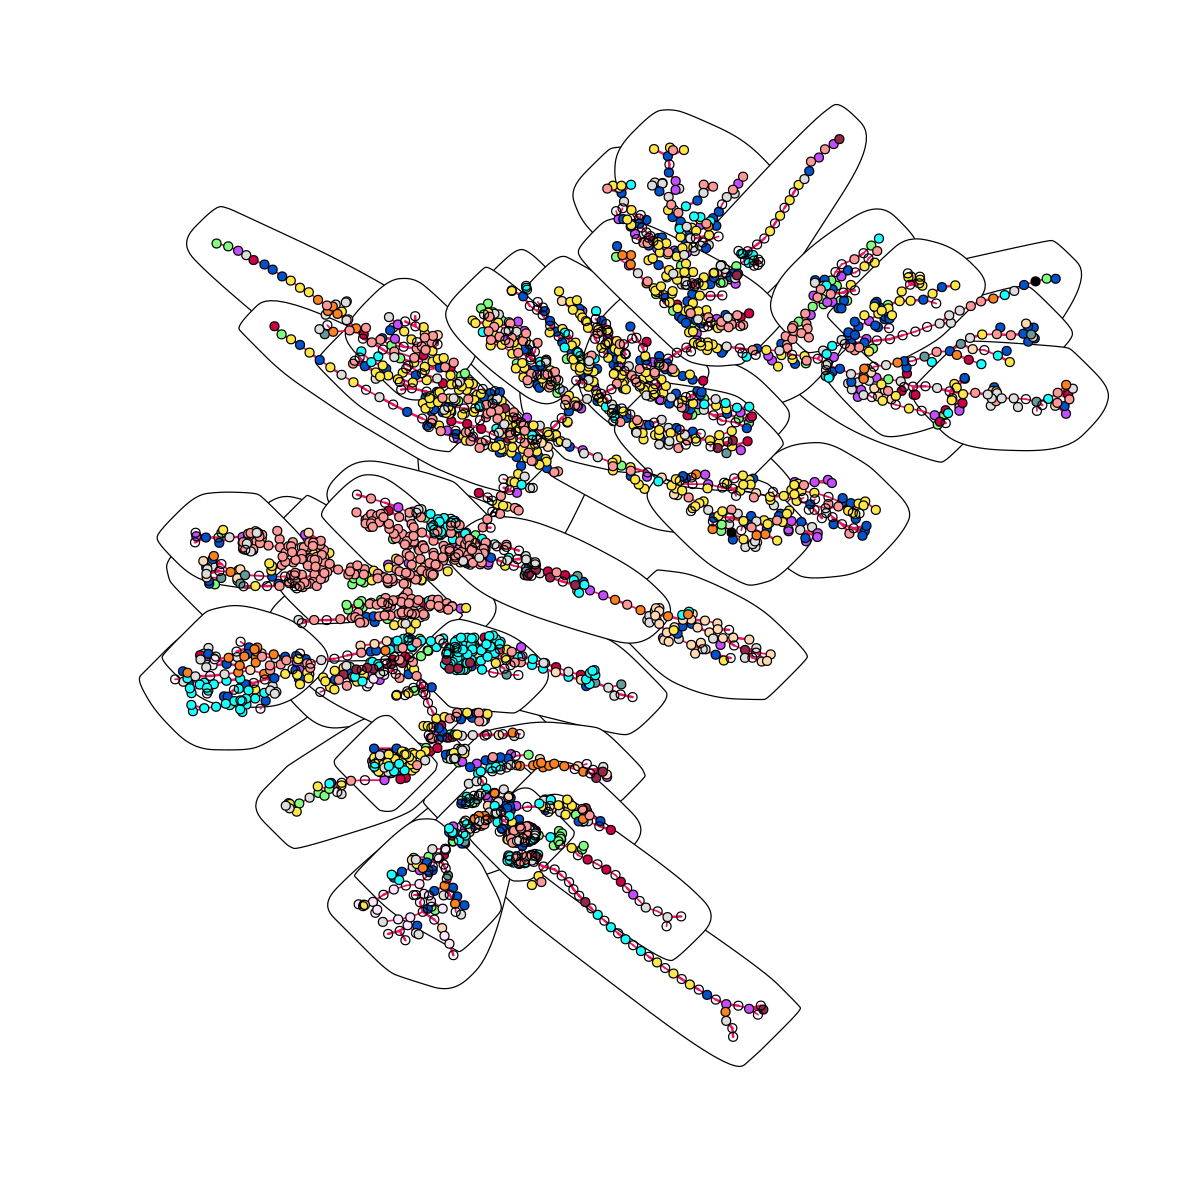

In [259]:
#setEPS()
#postscript("prot_network.eps")

plot(cb, main, col=V(main)$color, mark.border="black", mark.col=c("white"), edge.color=(E(main)$color),
    vertex.size=2, vertex.label=NA, edge.width=edgeweights, edge.curved=FALSE, vertex.shape="myimg",vertex.frame.width=1,vertex.frame.color="#000000",layout=layout_with_kk)
#dev.off()

In [490]:
grps <- split(V(main),cb$membership)
#grp <- unlist(subset(grps,mapply(`%in%`,5,grps)))
#df <- subset(get.data.frame(g),from %in% grp & to %in% grp)
grps

$`1`
+ 71/2938 vertices, named, from dcc34ed:
 [1]  Cercozoa_ko:K00700         Cercozoa_ko:K02114       
 [3]  Cercozoa_ko:K02133         Cercozoa_ko:K05863       
 [5]  Cercozoa_ko:K09499         Cercozoa_ko:K17982       
 [7]  Cercozoa_ko:K20782         Chlorophyta_ko:K00026    
 [9]  Chlorophyta_ko:K02183      Chlorophyta_ko:K02690    
[11]  Chlorophyta_ko:K05542      Chlorophyta_ko:K18164    
[13]  Ciliophora_ko:K00721       Ciliophora_ko:K02957     
[15]  Ciliophora_ko:K02995       Ciliophora_ko:K09568     
[17]  Ciliophora_ko:K11143       Cryptophyta_ko:K00026    
[19]  Cryptophyta_ko:K03283      Dinophyta_ko:K00235      
+ ... omitted several vertices

$`2`
+ 80/2938 vertices, named, from dcc34ed:
 [1]  Chlorophyta_ko:K01895                     
 [2]  Ciliophora_ko:K00134                      
 [3]  Ciliophora_ko:K02133                      
 [4]  Ciliophora_ko:K03234                      
 [5]  Ciliophora_ko:K04077                      
 [6]  Ciliophora_ko:K15102               

In [491]:
main.nodes<-mst.nodes

In [492]:
netm <- get.adjacency(main, attr="weight", sparse=F)

colnames(netm) <- V(main)$def

rownames(netm) <- V(main)$def


In [493]:
edge_density(main, loops=F)

[1] 0.0006807352

In [83]:
vertex_connectivity(main)

[1] 1

In [1268]:
mean_distance(main)

[1] 43.68215

In [1269]:
distance_table(main)

$res
  [1]  2935 17450 11291 14287 18002 25885 25418 37676 26956 32512 33941 37745
 [13] 40771 45111 43988 47872 51562 57925 55368 55549 58607 62728 62719 63401
 [25] 61804 65629 67420 68212 69453 73641 72549 76505 75127 83800 70499 76485
 [37] 70695 74926 75843 78263 82260 92266 80489 71881 68460 64701 62447 61805
 [49] 59390 55818 55289 54095 53874 50992 51254 51533 51888 50939 51032 47652
 [61] 48691 53114 51185 45575 51375 45938 43428 41264 43666 32967 31677 31373
 [73] 28008 24852 25773 24788 25051 21148 21881 22027 20704 21749 20035 15170
 [85] 16945 14493 11526 10419 11690 10337  9371 12337  8254  8089  8109  7186
 [97]  6502  6003  5795  5021  4947  4384  4304  3915  3848  3619  3724  3427
[109]  3171  3076  2706  2447  2259  1866  1645  1503   967   999   723   700
[121]   434   618   322   287   218   154    74    59    30    15     6     2

$unconnected
[1] 0

In [1270]:
ecount(main)/(vcount(main)*(vcount(main)-1))

[1] 0.0003405995

In [1271]:
reciprocity(main) #always 1 for an undirected graph

[1] 1

In [1272]:
closeness <- closeness(main)
degree <- degree(main)
betweenness <- betweenness(main)
eig <- evcent(main)$vector

In [1273]:
centrality <- data.frame(row.names   = V(main)$name,
                         degree      = degree,
                         closeness   = closeness,
                         betweenness = betweenness,
                         eigenvector = eig)

centrality <- centrality[order(row.names(centrality)),]

In [176]:
centralization.degree(main)

$res
   [1]  4  3  2  1  2  1  2  2  4  3  3  3  1  1  1  3  1  1  1  1  2  1  2  1
  [25]  2  1 15  3  2  1  3  5  1  1  1  2  6  2  1  1  2  1  1  1  2  1  1  1
  [49]  2  3  4  3  2  2  1  1  2  2  1  1  1  1  6  1  2  1  3  2  2  1  2  2
  [73]  3  2  4  1  1  2  5  1  1  2  2  1  5  2  2  2  3  1  3  4  2  3  1  2
  [97]  1  1  1  5  7  8  5  1  1  1  2  1  1  1  1  1  1  2  1  1  1  2  1  1
 [121]  1  4  1  1  4  1  1  1  1  1 13  1  1  2  5  1  1  2  4  1  2  1  2  1
 [145]  2  1  3  1  1  1  2  2  1  2  1  2  1  1  3  1  1  1  1  1  1  1  1  1
 [169]  2  2  2  7  1  1  1  1 89  2  1  3  1  2  1  2  1  3  4  2  1  1  1  4
 [193]  1  1  3  1  1  2  1  1  1  6  6  1  2  2  2  4  1  2  1  1  3  1  1  1
 [217]  1  1  1 15  2  1  1  1  1  1  1  3  1  1  1  2  1  1  3  4  1  1  2  1
 [241]  1  2  2  3  1  5  1  4  1  3  1  1  1  2  2  1  1  1  3  1  1  2  2  1
 [265]  1  1  2  1  4  2  2  1  5  1  3  1  1  1  1  4  1  1  1  1  1  1  1  1
 [289]  1  3  1  1  1  1  3  2  1  1  4  1  1  1  3  1  1  1  1  1  2  1  1  1
 [313]  1  3  1  1  1  1  1  3  2  8  1  1  1  3  2  2  1  1  1  1  2  1  1  1
 [337]  2  1  1  1  1  1  1  1  2  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1
 [361]  1  2  1  2  2  3  1  2  1  1  4  1  6  1  2 11  1  3  2  1  1  3  1  4
 [385]  3  1  1  1  1  1  1  1  5  1  1  4  4  1  4  1  1  2  1  1  2  1  1  1
 [409]  1  2  1  1  1  1  1  1  1  1  1  1  1  1  2  3  5  1  1  3  2  1  4  1
 [433]  1  2  3  1  2  5  1  1  1  3  1  1  1  1  1  1  1  1  3  2  1  5  1  1
 [457]  1  2  1  2  1  1  1  1  1  4  1  3  1  2  5  1  1  1  2  1  1  1  1  1
 [481]  1  1  1  1 13  1  2  1  1  1  1  2  2  2  2  1  1  2  1  2  1  1  1  2
 [505]  2  5  1  2  1  1  2  2  2  1  4  1  1  1  1  1  3  1  1  1  1  1  3  6
 [529]  1  1  1  1  1  1  1  1  1  1  1  2  1  1  2  1  2  1  2  1  1  1  1  1
 [553]  1  1  1  4  1  2  1  1  3  1  1  1  2  1  2  3  1  2  1  1  2  2  6  1
 [577]  1  1  1  1  2  1  3  3  2  1  1  2  1  2  6  1  4  1  4  1  1  4  1  3
 [601]  4  3  1  3  4  1 11  4  2  4  5  1  2  1  1  2  1  8  2  1  2  3  3  1
 [625]  1  4  1  1  2  2  1  1  4  1  1  1  1  1  2  1  3  1  2  4  2  1  3  1
 [649]  3  1  1  2  1  1  7  3  5  1  6  2  1  1  1  1  1  1  1  2  1  3  1  3
 [673]  1  2  1  1  2  1  1  1  2  1  2  1  4  3  3  1  2  1  1  2  3  1  3  4
 [697]  6  2  7  4  1  3  1  1  1  1  4  1  1  1  1  1  2  4  1  3  4  1  2  1
 [721]  1  6  1  1  1  2  5  4  1  2  1  1  1  2  1  1  1  1  1  1  1  1  1  1
 [745]  2  1  2  2  3  1  5  1  1  4  4  1  1  1  1  1  1  1  1  1  1  1  7  6
 [769]  1  1  1 11  2  2  1  2  3  1  6  5  2  3  1  2  3  3  4  1  1  1  1  1
 [793]  5  1  2  2  1  1  2  1  1  1  2  2  5  2  2  2  2  3  1  4  4  1  2  1
 [817]  1  2  2  1  1  2  1  1  1  2  2  1  2  1  1  1  1  2  1  1  1  1  1  2
 [841]  1  1  3  2  7  2  2  1  1  5  1  1  2  4  2  2  4  1  5  1  3  1  1  1
 [865]  1  7  1  1  1  2  1  2  1  2  1  1  5  1  1  1  1  1  1  1  3  1  4  5
 [889]  5  1 11  4  1  1  1  1  1  1  4  1  2  1  2  1  4  1  1  1  5  2  7  2
 [913]  1  1  1  1  2 15  2  1  1  1  1  2  6  1  1  2  2  2  1  1  1  1  3  1
 [937]  1  1  2  1  1  1  1  1  2  1  1  1  1  2  3  1  1  1  1  1  5  1  1  1
 [961]  3  1  1  1  1  1  3  1  2  1  1  2  2  3  1  1  2  3  1  4  1  1  1 19
 [985]  5  1  1  1  1  1  2  1  1  1  2  2  1  2  1  1  1  2  1  1  1  1  3  1
[1009]  1  4  1  3  2  1  2  2  2  1  1  1  1  3  1  1  1  1  1  1  1  3  1  2
[1033]  2  1  1  2  4  2  6  1  7  1  1  2  1  1  1  1  1  1  1  1  1  2  1  1
[1057]  1  1  1  1  3  3  3  1  1  2  1  2  1  1  2  2 33 79  3  3  1  1  1  2
[1081]  1  3  1  3  1  1  1  2  1  1  4  1  1  1  1  2  2  2  1  2  1 14  1  1
[1105]  1  1  2  1  1  5  1  1  1  1  1  1  1  2  1  3  1  1  1  1  4  1  3  2
[1129]  1  3  9  1  1  7  1  1  2  1  1  1  1  2  5  1  3  6  1  2  1  2  1  1
[1153]  2  2  2  1  1  5  1  3  1  1  9  2  5  1  1  1  2  1  1  4  1  2  1  1
[1177]  1  1  1  3  1  1  1  1  3  1  2  1  3  3  1  4  1  1  1  6  1  3  3  1
[1201]  1  1  2  2  5  2  1  2  1  1  3  1  1

In [416]:
max(centrality$degree)

[1] 89

In [178]:
degreemax<-88

In [373]:
sub<-centrality[centrality$degree %in% degreemax,]
sub #ammonium transporter is a highly connected node

degree closeness betweenness eigenvector

In [418]:
diameter(main, directed=F, weights=NA)

[1] 132

In [417]:
vcount(main)

[1] 2936

In [419]:
ecount(main)

[1] 2935

In [183]:
edge_density(main)

[1] 0.0006966214

In [ ]:
#From https://rstudio-pubs-static.s3.amazonaws.com/337696_c6b008e0766e46bebf1401bea67f7b10.html#degree-distribution
options(repr.plot.width = 5, repr.plot.height = 5)

deg <- degree(main, mode="all")
degree_distribution(main)

deg.dist <- degree_distribution(main, cumulative=T, mode="all")

plot( x=0:max(deg), y=1-deg.dist, pch=19, cex=1, col="black", 

      xlab="Degree", ylab="Cumulative Frequency")

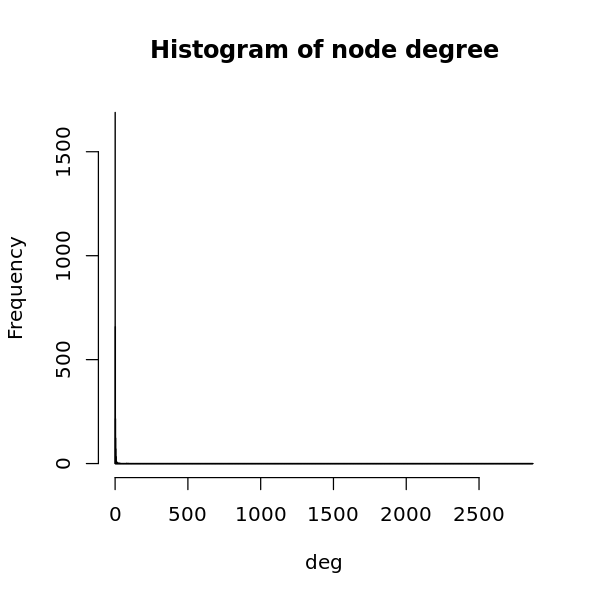

In [185]:
hist(deg, breaks=1:vcount(main)-1, main="Histogram of node degree")

In [494]:
length(cb)

[1] 56

In [495]:
modularity(cb)

[1] 0.962157

In [496]:
com <- cbind(V(main),cb$membership) #V(g) gets the number of vertices
com <- cbind(V(main)$name,cb$membership) #To get names if your vertices are labeled

In [497]:
df<-as.data.frame(com)
colnames(df)<-c('name','membership')
head(df)

name                       membership
1  Ancyromonadidae_ko:K00364 21        
2  Apicomplexa_ko:K00134     23        
3  Apicomplexa_ko:K01803     23        
4  Apicomplexa_ko:K02115     32        
5  Apicomplexa_ko:K02966     54        
6  Apicomplexa_ko:K03231     3

In [498]:
merge<-merge(df, main.nodes,by='name')
head(merge)

name                       membership vertex.frame.color color  
1  Ancyromonadidae_ko:K00364 21         black              #dddddd
2  Apicomplexa_ko:K00134     23         black              #dddddd
3  Apicomplexa_ko:K01803     23         black              #dddddd
4  Apicomplexa_ko:K02115     32         black              #dddddd
5  Apicomplexa_ko:K02966     54         black              #dddddd
6  Apicomplexa_ko:K03231     3          black              #dddddd
  taxa             ko       
1  Ancyromonadidae ko:K00364
2  Apicomplexa     ko:K00134
3  Apicomplexa     ko:K01803
4  Apicomplexa     ko:K02115
5  Apicomplexa     ko:K02966
6  Apicomplexa     ko:K03231

In [499]:
ye <- merge %>% count(membership, ko)
head(ye)
library(caroline)
sum<-groupBy(ye, by='membership',clmn=c('n'),aggregation='sum')
sum$membership<-rownames(sum)
colnames(sum)<-c('sum','membership')
count<-merge(sum, ye, by='membership')
count$ratio<-count$n/count$sum
head(count)

count$membership <- factor(count$membership, levels = (1:56), ordered=TRUE) 
levels(count$membership)

membership ko        n
1 1          ko:K00012 1
2 1          ko:K00026 2
3 1          ko:K00128 1
4 1          ko:K00135 1
5 1          ko:K00235 1
6 1          ko:K00323 1

membership sum ko        n ratio     
1 1          71  ko:K00012 1 0.01408451
2 1          71  ko:K00026 2 0.02816901
3 1          71  ko:K00128 1 0.01408451
4 1          71  ko:K00135 1 0.01408451
5 1          71  ko:K00235 1 0.01408451
6 1          71  ko:K00323 1 0.01408451

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35" "36" "37" "38" "39" "40" "41" "42" "43" "44" "45"
[46] "46" "47" "48" "49" "50" "51" "52" "53" "54" "55" "56"

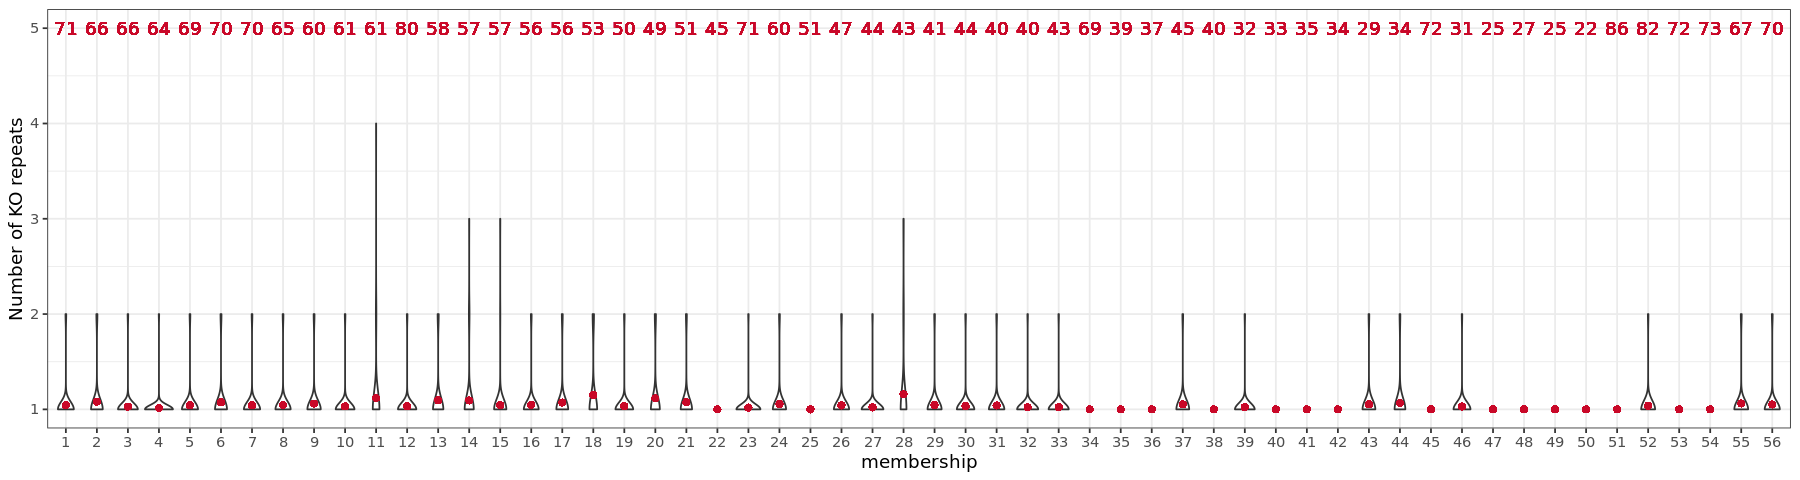

In [562]:
#Investigating the number of repeated KOs in modules (i.e., are they grouped by identical function?)
library(ggplot2)
options(repr.plot.width = 15, repr.plot.height = 4)
ggplot(count, aes(x=membership, y=n)) + 
  geom_violin() + theme_bw() + ylab("Number of KO repeats") + geom_text(aes(label = sum, x = membership, y = 5), data = count, color = '#c90828') + stat_summary(fun.y=mean, geom="point", shape=16, size=2,color = '#c90828')
#ggsave(file="prot_network_ko_repeats.eps", g, dpi = 600, width = 15, height = 5.5)

In [501]:
merge3<-merge(df, main.nodes,by='name')
head(merge3)

name                       membership vertex.frame.color color  
1  Ancyromonadidae_ko:K00364 21         black              #dddddd
2  Apicomplexa_ko:K00134     23         black              #dddddd
3  Apicomplexa_ko:K01803     23         black              #dddddd
4  Apicomplexa_ko:K02115     32         black              #dddddd
5  Apicomplexa_ko:K02966     54         black              #dddddd
6  Apicomplexa_ko:K03231     3          black              #dddddd
  taxa             ko       
1  Ancyromonadidae ko:K00364
2  Apicomplexa     ko:K00134
3  Apicomplexa     ko:K01803
4  Apicomplexa     ko:K02115
5  Apicomplexa     ko:K02966
6  Apicomplexa     ko:K03231

In [502]:
def<-read.tab('rest.kegg.jp.txt')
colnames(def)<-c('ko','def')
merge4<-merge(merge3, def, by='ko',all=T)
write.csv(merge4, 'membership_ko_taxa_network_proteins.csv')


In [503]:
netm <- get.adjacency(main, attr="weight", sparse=F)
palf <- colorRampPalette(c("gold", "dark orange"))

In [504]:
library(dplyr)

In [505]:
taxa <- merge %>% count(membership, taxa) #count each time a taxon appears in a membership cluster

In [506]:
taxa$membership <- factor(taxa$membership, levels = (1:56), ordered=TRUE) 
levels(taxa$membership)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35" "36" "37" "38" "39" "40" "41" "42" "43" "44" "45"
[46] "46" "47" "48" "49" "50" "51" "52" "53" "54" "55" "56"

In [507]:
library(ggplot2)

In [508]:
cols <- c(' Chlorophyta'='#80ff80', ' Ciliophora'='#c44dff', ' Collodictyonidae'='#ccccff', ' Cryptophyta'='#cc0044', ' Dinophyta'='#0052cc', ' Discoba'='#ffd9b3',' Foraminifera'='#669999',' Fungi'='#FFE6FF',' Haptophyta'='#FFE74A', ' Lobosa'='#000000',' Marine_stramenopiles_MASTs group'='#9c7b11',' Metazoa'='#1affff',' Picozoa'='#fc8123',' Radiolaria'='#942649',' Stramenopiles'='#ff9999',' Ancyromonadidae'='#dddddd', ' Apicomplexa'='#dddddd',' Centroplasthelida'='#dddddd',' Cercozoa'='#dddddd',' Choanoflagellata'='#dddddd',' Choanoflagellida'='#dddddd',' Colpodellida'='#dddddd',' Colponemidia'='#dddddd',' Corallochytrium'='#dddddd',' Endomyxa'='#dddddd',' Evosea'='#dddddd',' Filasterea'='#dddddd',' Glaucocystophyta'='#dddddd',' Ichthyosporea'='#dddddd',' Loukozoa'='#dddddd',' Mantamonadidae'='#dddddd',' Marine'='#dddddd',' Oomycota'='#dddddd',' Perkinsea'='#dddddd',' Prasinodermophyta'='#dddddd',' Rhodelphida'='#dddddd',' Rhodophyta'='#dddddd',' Squirmida'='#dddddd',' Streptophyta'='#dddddd',' Telonemia'='#dddddd',' Tubulinea'='#dddddd')

#cols <- c(' Chlorophyta'='#80ff80', ' Ciliophora'='#c44dff', ' Collodictyonidae'='#ccccff', ' Cryptophyta'='#cc0044', ' Dinophyta'='#0052cc', ' Discoba'='#ffd9b3',' Foraminifera'='#669999',' Fungi'='#FFE6FF',' Haptophyta'='#FFE74A', ' Lobosa'='#000000',' Marine_stramenopiles_MASTs group'='#9c7b11',' Metazoa'='#1affff',' Picozoa'='#fc8123',' Radiolaria'='#942649',' Stramenopiles'='#ff9999', ' Ancyromonadidae'='#DD5282',' Apicomplexa'='#75B088',' Centroplasthelida'='#D352DF',' Cercozoa'='#62E2C5',' Choanoflagellata'='#B06753',' Choanoflagellida'='#000000',' Colpodellida'='#000000',' Colponemidia'='#000000',' Corallochytrium'='#000000','  Endomyxa'='#000000',' Evosea'='#000000',' Filasterea'='#000000',' Glaucocystophyta'='#000000',' Ichthyosporea'='#000000',' Loukozoa'='#000000',' Mantamonadidae'='#000000',' Marine'='#000000',' Oomycota'='#000000',' Perkinsea'='#6068DD',' Prasinodermophyta'='#6996ED',' Rhodelphida'='#DDBA89',' Rhodophyta'='#E5AFBE',' Squirmida'='#4AB95B',' Streptophyta'='#B06753',' Telonemia'='#62E2C5',' Tubulinea'='#D352DF')




In [509]:
options(repr.plot.width = 15, repr.plot.height = 5)

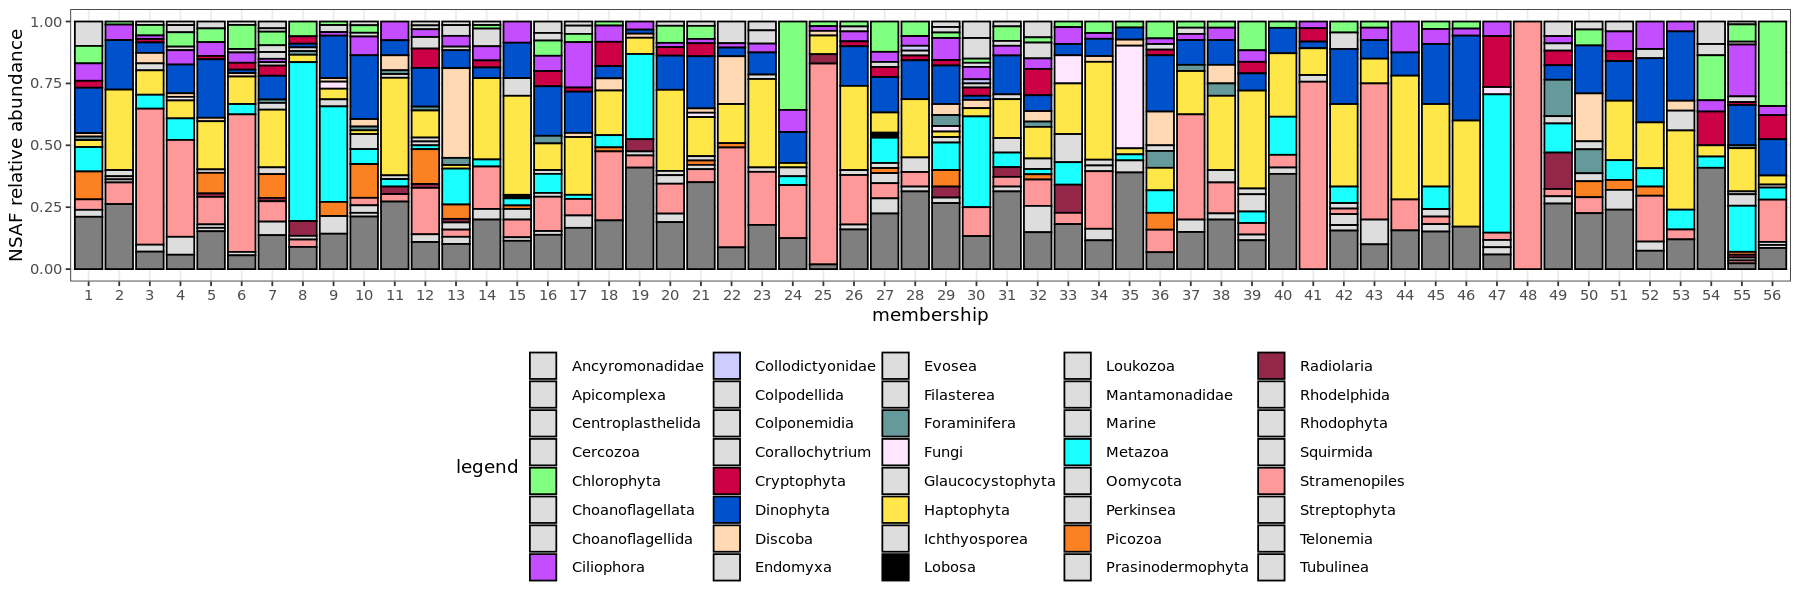

In [510]:
ggplot(taxa, aes(fill=taxa, y=n, x=membership)) + 
    geom_bar(position="fill", stat="identity",colour="black") + theme_bw() + ylab("NSAF relative abundance") + theme(legend.position = "bottom") + scale_fill_manual("legend",values=cols)
#ggsave(file="prot_network_taxa.eps", g, dpi = 600, width = 15, height = 5.5)

In [511]:
ko<-main.nodes$ko

In [512]:
ko2<-unique(ko)

In [513]:
ko2brite<-read.csv('ko2brite.csv',header=TRUE, stringsAsFactors=FALSE, fileEncoding="latin1") #"Enzyme" category not included - too broad

In [514]:
colnames(ko2brite)<-c('BRITE','ko','x','x1','x2')
merge2<-merge(ko2brite, merge, by='ko',all=T) #If KO has two BRITE categories, each BRITE gets 1 KO count
test1<-merge2[!is.na(merge2$name), ] #Remove KO/BRITE rows without matches to dataset
merge2<-test1

In [515]:
head(merge2)

ko        BRITE x  x1 x2 name                       membership
1 ko:K00001 NA    NA NA NA  Dinophyta_ko:K00001       10        
3 ko:K00006 NA    NA NA NA  Haptophyta_ko:K00006      11        
4 ko:K00006 NA    NA NA NA NA_ko:K00006               17        
5 ko:K00012 NA    NA NA NA  Dinophyta_ko:K00012       36        
6 ko:K00012 NA    NA NA NA  Haptophyta_ko:K00012      2         
7 ko:K00012 NA    NA NA NA  Stramenopiles_X_ko:K00012 1         
  vertex.frame.color color   taxa          
1 black              #0052cc  Dinophyta    
3 black              #FFE74A  Haptophyta   
4 black              NA      NA            
5 black              #0052cc  Dinophyta    
6 black              #FFE74A  Haptophyta   
7 black              #ff9999  Stramenopiles

In [516]:
func <- merge2 %>% count(membership, BRITE) #count each time a BRITE category appears in a membership cluster

In [517]:
options(repr.plot.width = 15, repr.plot.height = 5.5)

In [518]:
KO<-c('ko01007 Amino acid related enzymes','ko01009 Protein phosphatases and associated proteins','ko01002 Peptidases and inhibitors','ko01001 Protein kinases','ko04031 GTP-binding proteins','ko03012 Translation factors','ko03011 Ribosome','ko03009 Ribosome biogenesis','ko03019 Messenger RNA biogenesis','ko03036 Chromosome and associated proteins','ko03021 Transcription machinery','ko03016 Transfer RNA biogenesisæ','ko03400 DNA repair and recombination proteins','ko03032 DNA replication proteins','ko03000 Transcription factors','ko00194 Photosynthesis proteinsæ','ko03029 Mitochondrial biogenesis','ko04040 Ion channels','ko02000 Transporters','ko04090 CD molecules','ko04131 Membrane trafficking','ko02044 Secretion system','ko04030 G protein-coupled receptors','ko01003 Glycosyltransferases','ko00536 Glycosaminoglycan binding proteins','ko01004 Lipid biosynthesis proteins','ko04091 Lectins','ko00537 Glycosylphosphatidylinositol (GPI)-anchored proteins','ko01008 Polyketide biosynthesis proteins','ko03051 Proteasome','ko04121 Ubiquitin system','ko03041 Spliceosome','ko03110 Chaperones and folding catalysts','ko04147 Exosome','ko04515 Cell adhesion molecules','ko02035 Bacterial motility proteinsæ','ko04054 Pattern recognition receptors','ko00199 Cytochrome P450','ko04990 Domain-containing proteins not elsewhere classified','ko04812 Cytoskeleton proteins','Other')

In [519]:
func$BRITE <- factor(func$BRITE, levels = KO, ordered=TRUE)

In [520]:
kegg<-c('ko01007 Amino acid related enzymes'='#FA0404','ko01009 Protein phosphatases and associated proteins'='#FB5F5F','ko01002 Peptidases and inhibitors'='#FB9F9F','ko01001 Protein kinases'='#BD4646','ko04031 GTP-binding proteins'='#F2670D','ko03012 Translation factors'='#D67637','ko03011 Ribosome'='#B85A1C','ko03009 Ribosome biogenesis'='#984610','ko03019 Messenger RNA biogenesis'='#F6BA0E','ko03036 Chromosome and associated proteins'='#DBB340','ko03021 Transcription machinery'='#AFA619','ko03016 Transfer RNA biogenesisæ'='#E6DA1E','ko03400 DNA repair and recombination proteins'='#FBEC06','ko03032 DNA replication proteins'='#CEFB06','ko03000 Transcription factors'='#BFE125','ko00194 Photosynthesis proteinsæ'='#3CFA04','ko03029 Mitochondrial biogenesis'='#4EC62A','ko04040 Ion channels'='#37D782','ko02000 Transporters'='#1DB062','ko04090 CD molecules'='#2DF7BD','ko04131 Membrane trafficking'='#16B98A','ko02044 Secretion system'='#16E6E3','ko04030 G protein-coupled receptors'='#19BBB9','ko01003 Glycosyltransferases'='#19A0BB','ko00536 Glycosaminoglycan binding proteins'='#0B6D81','ko01004 Lipid biosynthesis proteins'='#0c1a63','ko04091 Lectins'='#1F8ACB','ko00537 Glycosylphosphatidylinositol (GPI)-anchored proteins'='#0A6FF7','ko01008 Polyketide biosynthesis proteins'='#043BF7','ko03051 Proteasome'='#2E08C8','ko04121 Ubiquitin system'='#5643A5','ko03041 Spliceosome'='#9084C4','ko03110 Chaperones and folding catalysts'='#9D24EB','ko04147 Exosome'='#B96BEB','ko04515 Cell adhesion molecules'='#F028E3','ko02035 Bacterial motility proteinsæ'='#D87AD2','ko04054 Pattern recognition receptors'='#F93875','ko00199 Cytochrome P450'='#f296b9','ko04990 Domain-containing proteins not elsewhere classified'='#f0dfe7','ko04812 Cytoskeleton proteins'='#FFFFFE','Other'='#000000')

In [521]:
func$membership <- factor(func$membership, levels = (1:58), ordered=TRUE)

In [522]:
library(ggplot2)

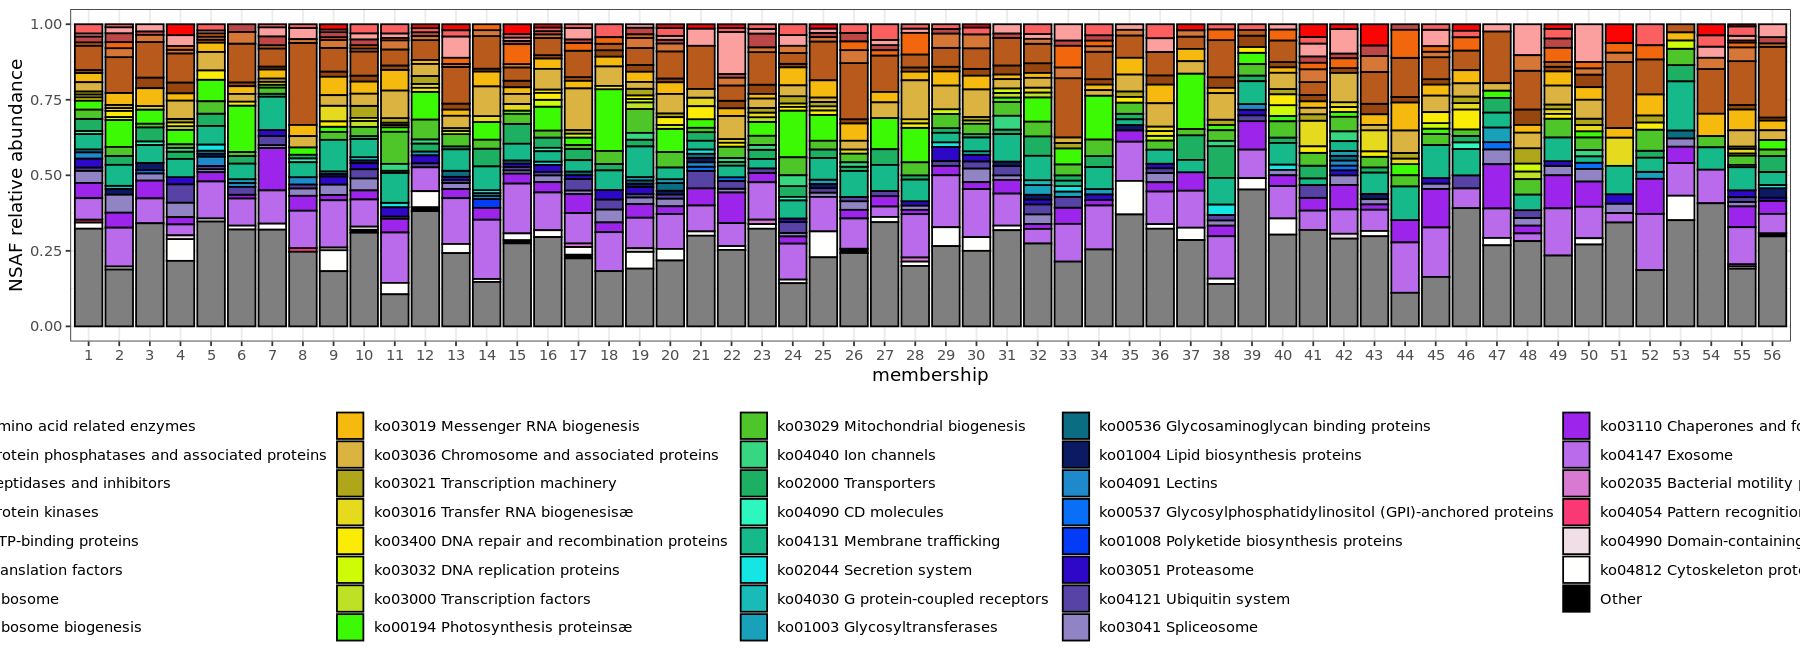

In [523]:
ggplot(func, aes(fill=BRITE, y=n, x=membership)) + 
    geom_bar(position="fill", stat="identity", colour="black") + theme_bw() + ylab("NSAF relative abundance") + theme(legend.position = "bottom") + scale_fill_manual("legend",values=kegg)
#ggsave(file="prot_network_kegg_split.eps", g, dpi = 600, width = 30, height = 5.5)

In [524]:
library(tmod)

In [525]:
membership<-as.data.frame(com)

In [526]:
colnames(membership)<-c('gene_id','geneset_id')

In [527]:
res <- makeTmodFromDataFrame(membership, feature_col="gene_id", module_col="geneset_id")

unlisting m2g

making Tmod



In [528]:
eig<-eigengene(d, rownames(d), res)

In [529]:
cor_eig<-cor(eig)

In [530]:
library(ggcorrplot)

In [531]:
p.mat <- ggcorrplot::cor_pmat(cor_eig)

In [532]:
head(p.mat)

1_30_0.2     1_115_0.2    1_30_3       1_115_3      1_150       
1_30_0.2  0.000000e+00 2.598876e-01 6.657634e-19 4.955264e-21 2.570253e-03
1_115_0.2 2.598876e-01 0.000000e+00 4.499380e-01 3.244549e-02 2.114255e-14
1_30_3    6.657634e-19 4.499380e-01 0.000000e+00 3.603543e-14 2.748587e-03
1_115_3   4.955264e-21 3.244549e-02 3.603543e-14 0.000000e+00 1.166594e-01
1_150     2.570253e-03 2.114255e-14 2.748587e-03 1.166594e-01 0.000000e+00
1_200     7.833349e-18 7.492853e-03 5.945385e-13 1.006494e-16 1.171674e-02
          1_200        1_300        1_400        1_600        1_800        ⋯
1_30_0.2  7.833349e-18 1.560656e-18 4.365074e-18 7.996026e-18 4.585681e-10 ⋯
1_115_0.2 7.492853e-03 1.879017e-03 1.493941e-03 1.298132e-03 4.945492e-03 ⋯
1_30_3    5.945385e-13 1.339002e-13 2.070638e-13 1.338995e-13 9.407615e-09 ⋯
1_115_3   1.006494e-16 5.718260e-20 4.226632e-20 1.214765e-20 1.069002e-11 ⋯
1_150     1.171674e-02 1.386367e-01 1.748188e-01 2.397220e-01 4.171354e-01 ⋯
1_200     0.000000e+00 1.872993e-59 1.094155e-56 4.208080e-50 4.035379e-17 ⋯
          7_150        7_300        8_20         8_40         8_120       
1_30_0.2  6.124700e-15 6.775812e-19 3.231104e-18 1.702199e-10 1.435314e-08
1_115_0.2 5.900606e-02 1.025698e-03 3.722005e-02 1.662891e-03 2.589808e-02
1_30_3    2.832697e-11 7.739792e-14 6.145759e-14 6.397954e-09 1.889210e-07
1_115_3   4.785430e-11 3.903884e-21 7.468409e-18 5.070666e-12 4.263054e-09
1_150     8.166935e-05 2.620593e-01 8.864356e-03 2.706466e-01 2.193996e-01
1_200     8.509837e-47 2.676178e-49 3.466455e-35 8.733977e-21 8.721646e-14
          8_175        8_400        8_800        8_250        8_600       
1_30_0.2  1.255829e-17 4.022240e-17 1.168431e-15 1.903348e-18 1.182048e-12
1_115_0.2 5.076913e-04 4.896898e-04 4.339311e-04 1.231501e-03 7.709699e-04
1_30_3    4.528217e-13 2.367989e-13 3.916812e-12 7.395616e-14 2.695669e-10
1_115_3   3.497524e-21 4.225129e-21 8.430521e-19 6.396557e-21 3.028151e-15
1_150     5.524247e-01 6.388608e-01 8.131829e-01 3.883125e-01 9.656295e-01
1_200     2.037296e-39 7.988997e-34 6.287659e-24 2.079267e-41 6.356037e-17

In [533]:
#ggcorrplot(cor_eig,hc.order=TRUE,colors = c("#0FFF50", "#FFFFFE", "#5F03FB"),outline="black",p.mat=p.mat, sig.level=0.05)

In [534]:
t_eig<-t(eig)
t_eig<-as.data.frame(t_eig)

In [535]:
t_eig$ID<-rownames(t_eig)
t_eig<-as.data.frame(t_eig)

In [536]:
cors<-read.csv('correlations.csv')

In [537]:
library(ggcorrplot)

In [538]:
options(repr.plot.width = 20, repr.plot.height = 20)

In [539]:
cors<-cors[with(cors, order(ID)),] #sort by ID

In [540]:
 t_eig<-t_eig[with(t_eig, order(ID)),] #sort by ID

In [541]:
t_eig<-t_eig[(t_eig$ID %in% cors$ID),] #remove rows not shared in other df

In [542]:
cors<-cors[(cors$ID %in% t_eig$ID),] #remove rows not shared in other df

In [543]:
cors<-cors[,-1]
cors<-cors[,-2]

In [544]:
head(t_eig)

21         23         32         54         3          7         
1_115_0.2 -1.0662738 -1.8822344 -0.8044276 -0.5356001  0.1341245 -0.9100057
1_115_3   20.1035053  1.3829826 -0.4485788 -0.5356001 -0.5138235 -0.9100057
1_200     -0.4330591 -2.1346926 -0.6080534 -0.5356001 -1.4495898 -0.9100057
1_30_0.2   1.2357637 -0.2906882 -0.8414852 -0.5356001 -1.5318484 -0.9100057
1_30_3    11.5976244  5.5150575 -0.8414852 -0.5356001 -1.3151640 -0.9100057
1_400     -1.0693401 -2.3030901 -0.8414852 -0.5356001 -1.7860526 -0.9100057
          16        31         6          55        ⋯ 11         15        
1_115_0.2  1.048986 -0.6660020 -0.6531925 -1.002282 ⋯ -0.9043894 -1.2558343
1_115_3   10.567115 -0.6660020 -0.4850750 -1.002282 ⋯  5.8309381  2.3202317
1_200     -1.849766 -0.6660020 -1.8434570 -1.002282 ⋯ -2.1951604 -3.0818686
1_30_0.2  14.106809 -0.6660020 -2.0710681 -1.002282 ⋯  0.2064445  0.6585181
1_30_3     8.779251 -0.6470386 -1.1918127 -1.002282 ⋯  9.1748982  1.9256950
1_400     -2.204517 -0.6660020 -2.3305974 -1.002282 ⋯ -3.4973405 -3.2601970
          52          41         19         44        53         47        
1_115_0.2 -0.61035469 -0.7750125 -0.8519545 -0.897765 -0.7756092 -0.6492268
1_115_3   -0.61035469 -0.7750125 -0.8519545  4.291063 -0.7756092 -0.6492268
1_200     -0.61035469 -0.7750125 -0.8519545 -2.921314 -0.7756092 -0.6492268
1_30_0.2  -0.05829014 -0.7750125 -0.8519545  2.923690 -0.7756092 -0.6492268
1_30_3    -0.61035469 -0.7750125 -0.8519545  6.024819 -0.7756092 -0.6492268
1_400     -0.61035469 -0.7750125 -0.8519545 -3.067496 -0.7756092 -0.6492268
          48        ID       
1_115_0.2 -0.236775 1_115_0.2
1_115_3   -1.102743 1_115_3  
1_200     -1.102743 1_200    
1_30_0.2  -1.102743 1_30_0.2 
1_30_3    -1.102743 1_30_3   
1_400     -1.102743 1_400

In [545]:
t_eig<-t_eig[,-57] #spearman

In [546]:
colnames(t_eig)<-as.factor(colnames(t_eig))

In [547]:
library(psych)
correlation<-corr.test(x=t_eig,y=cors, method=c("spearman"))

In [548]:
p.mat <- correlation$p

In [549]:
options(repr.plot.width = 20, repr.plot.height = 5)

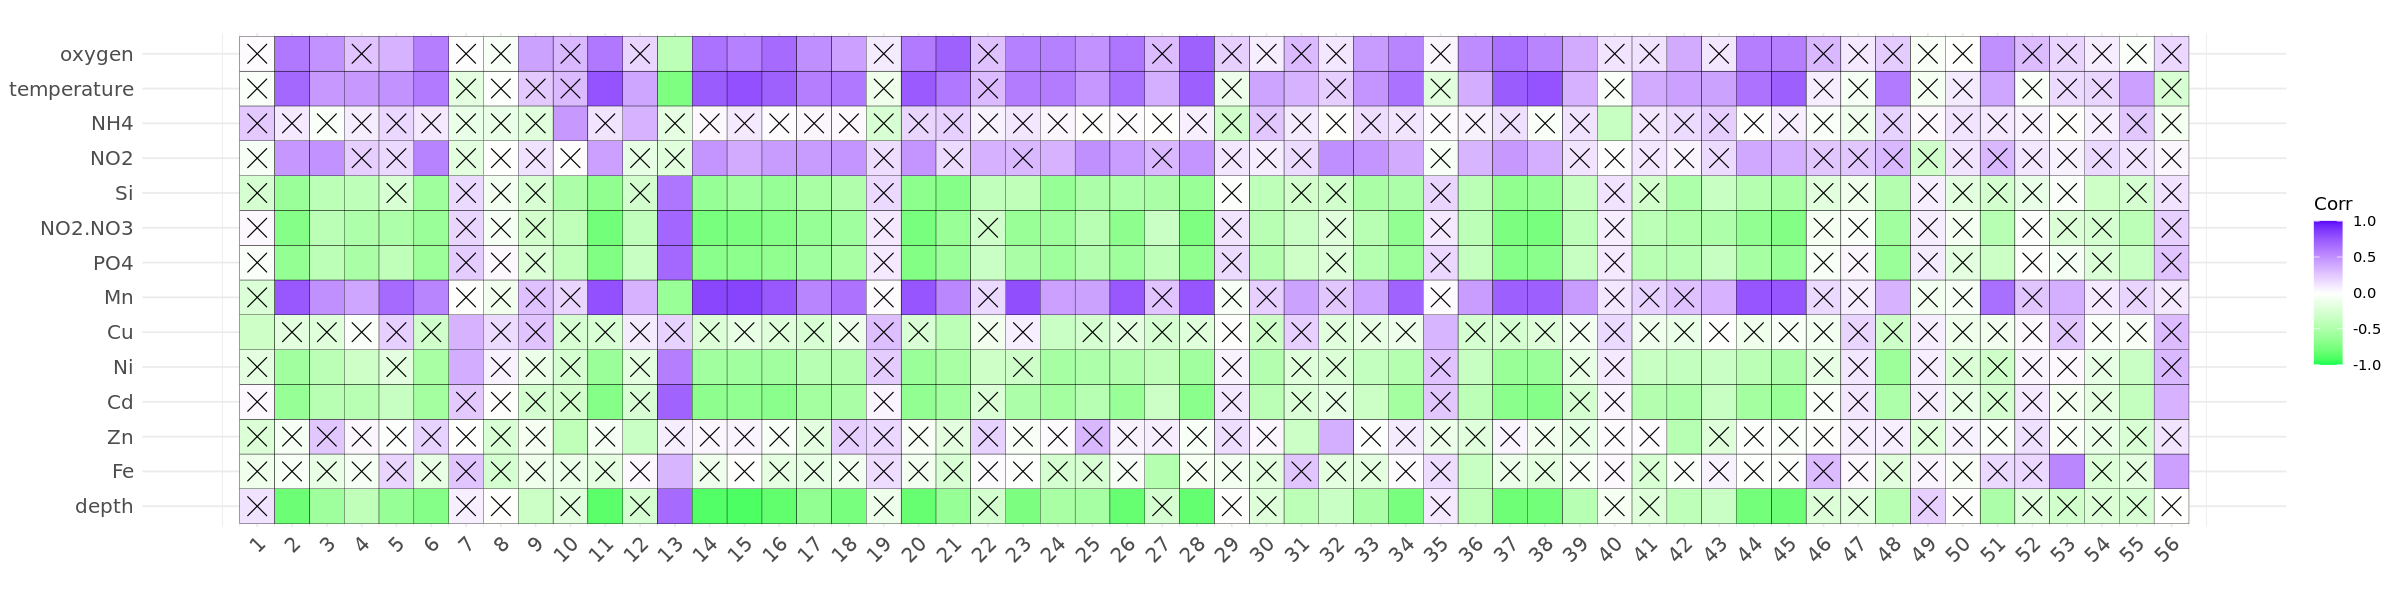

In [552]:
ggcorrplot(correlation$r,colors = c("#0FFF50", "#FFFFFE", "#5F03FB"),outline="black", p.mat=p.mat,sig.level=0.05) + ggplot2::scale_x_continuous(breaks = seq(1, 56, 1))
#ggsave(file="prot_network_correlation.eps", g, dpi = 600, width = 20, height = 5)

In [872]:
main

IGRAPH 01a3bfd UNW- 2411 2410 -- 
+ attr: name (v/c), vertex.frame.color (v/c), color (v/c), weight
| (e/n), color (e/c)
+ edges from 01a3bfd (vertex names):
[1]  Haptophyta_ko:K00006     -- Haptophyta_ko:K00505     
[2]  Haptophyta_ko:K00006     -- Dinophyta_ko:K01251      
[3]  Haptophyta_ko:K00006     -- Dinophyta_ko:K03927      
[4]  Haptophyta_ko:K00006     -- Haptophyta_ko:K11087     
[5]  Haptophyta_ko:K00012     -- Haptophyta_ko:K02908     
[6]  Haptophyta_ko:K00012     -- Ciliophora_ko:K03234     
[7]  Haptophyta_ko:K00012     -- Haptophyta_ko:K04345     
+ ... omitted several edges

# PLS regression with proteins

From above, read in spectral counts, NSAF normalize, read in eggnog annotations and split by KO. Begin with merged product under variable ("x")

In [580]:
gois<-read.csv('Sun2021ISME.csv') #List of nutrient-related KEGG genes from Sun et al. (2021) ISME
gois$KO_def<-paste(gois$KO, gois$def,sep='_')
colnames(gois)<-c('KEGG_ko','def','id','KO_def')

In [19]:
#Separate out by groups of genes
#select<-c('iron','copper','nickel','zinc','divalent metal','siderophore','manganese')
#select<-c('nitrogen', 'phosphorus','carbon','transcription factor')
#goi<-new[new$id %in% select,]

In [573]:
d <- x %>%
    group_by(KEGG_ko) %>% summarise_all(funs(sum))
d<-as.data.frame(d)
rownames(d)<-d$KEGG_ko
head(d)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


KEGG_ko   1_30_0.2   1_115_0.2   1_30_3     1_115_3   1_150     
ko:K00001 ko:K00001 0.00000000 0.000000000 0.00000000 0.0000000 0.00000000
ko:K00006 ko:K00006 0.06259445 0.000000000 0.42840068 0.3882696 0.00000000
ko:K00012 ko:K00012 0.01112216 0.009859367 0.02102916 0.0000000 0.03401045
ko:K00015 ko:K00015 0.00000000 0.000000000 0.00000000 0.0000000 0.00000000
ko:K00016 ko:K00016 0.00000000 0.000000000 0.00000000 0.0000000 0.00000000
ko:K00024 ko:K00024 0.00000000 0.000000000 0.00000000 0.0000000 0.00000000
          1_200 1_300 1_400 1_600      ⋯ 7_150      7_300 8_20       8_40      
ko:K00001 0     0     0     0.00000000 ⋯ 0.01425816 0     0.00000000 0.00000000
ko:K00006 0     0     0     0.00000000 ⋯ 0.00000000 0     0.07785951 0.05930523
ko:K00012 0     0     0     0.00000000 ⋯ 0.00000000 0     0.07961265 0.04646172
ko:K00015 0     0     0     0.00000000 ⋯ 0.00000000 0     0.00000000 0.00000000
ko:K00016 0     0     0     0.00000000 ⋯ 0.00000000 0     0.05177000 0.02936856
ko:K00024 0     0     0     0.04045171 ⋯ 0.00000000 0     0.00000000 0.00000000
          8_120 8_175 8_400      8_800 8_250 8_600
ko:K00001 0     0     0.00000000 0     0     0    
ko:K00006 0     0     0.00000000 0     0     0    
ko:K00012 0     0     0.02475994 0     0     0    
ko:K00015 0     0     0.00000000 0     0     0    
ko:K00016 0     0     0.00000000 0     0     0    
ko:K00024 0     0     0.00000000 0     0     0

In [581]:
library(dplyr) #Sum all euk divisions together

In [583]:
e<-merge(d, gois, by='KEGG_ko')
rownames(e)<-e$KO_def
e<-e[,-1]
e<-e[,-89]
e<-e[,-88]
e<-e[,-87]
head(e)

1_30_0.2
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1] 0       
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     0       
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      0       
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     0       
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                        0       
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                           0       
                                                                                            1_115_0.2
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1] 0        
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     0        
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      0        
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     0        
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                        0        
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                           0        
                                                                                            1_30_3    
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1] 0.02117935
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     0.00000000
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      0.00000000
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     0.00000000
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                        0.00000000
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                           0.00000000
                                                                                            1_115_3   
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1] 0.03394501
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     0.01730887
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      0.00000000
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     0.00000000
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                        0.00000000
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                           0.00000000
                                                                                            1_150     
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1] 0.06446596
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     0.00000000
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      0.00000000
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     0.00000000
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                        0.00000000
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                           0.00000000
                                                                                            1_200
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1] 0    
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     0    
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      0    
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     0    
ko:K00266_gltD; gl

In [584]:
e<-e[apply(e[,-1], 1, function(x) !all(x==0)),] #remove rows with all 0

In [585]:
e<-e[apply(e[,-1], 1, function(x) !all(x<0.01)),] #remove rows with aggregated KO sum (across divisions) less than 0.01 NSAF

In [577]:
t.e<-as.data.frame(t(e))

In [26]:
t.e<-as.data.frame(t(e))
cor<-read.csv('correlations.csv') #read in environmental metdata
rownames(cor)<-cor$ID
cor<-cor[,-1]
cor<-cor[,-2]
head(cor)

depth Fe   Zn   Cd     Ni   Cu   Mn   PO4  NO2.NO3 Si  NO2  NH4 
1_30_0.2   30   0.53 0.73 0.0035 1.96 0.89 1.93 0.18 0.2     0.3 0.02 0.09
1_30_3     30   0.53 0.73 0.0035 1.96 0.89 1.93 0.18 0.2     0.3 0.02 0.09
1_115_0.2 115   0.19 1.03 0.0072 2.00 0.91 0.94 0.23 1.4     0.4 0.10 0.00
1_115_3   115   0.19 1.03 0.0072 2.00 0.91 0.94 0.23 1.4     0.4 0.10 0.00
1_200     200   0.23 1.46 0.0103 2.04 1.00 0.68 0.20 1.4     0.3 0.02 0.14
1_400     400   0.25 1.56 0.0240 2.17 0.82 0.32 0.40 4.2     1.2 0.02 0.04
          temperature oxygen 
1_30_0.2  22.7522     218.696
1_30_3    22.7522     218.696
1_115_0.2 19.8370     216.766
1_115_3   19.8370     216.766
1_200     19.2741     209.082
1_400     18.3555     196.454

In [27]:
#BiocManager::install('mixOmicsTeam/mixOmics@1923e1a3987c7bd4de1c9610dd157e61639c472e')
library('mixOmics')

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice

Loading required package: ggplot2


Loaded mixOmics 6.13.114
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')




In [28]:
#Remove the rows (samples) without corresponding metadata

In [29]:
t.e$ID<-rownames(t.e)
cor$ID<-rownames(cor)
merge<-merge(t.e, cor, by='ID')

In [30]:
rownames(merge)<-merge$ID

In [31]:
head(merge)

ID       
1_115_0.2 1_115_0.2
1_115_3   1_115_3  
1_200     1_200    
1_30_0.2  1_30_0.2 
1_30_3    1_30_3   
1_400     1_400    
          ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]
1_115_0.2 0.00000000                                                                                 
1_115_3   0.03394501                                                                                 
1_200     0.00000000                                                                                 
1_30_0.2  0.00000000                                                                                 
1_30_3    0.02117935                                                                                 
1_400     0.00000000                                                                                 
          ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]
1_115_0.2 0.00000000                                                             
1_115_3   0.01730887                                                             
1_200     0.00000000                                                             
1_30_0.2  0.00000000                                                             
1_30_3    0.00000000                                                             
1_400     0.00000000                                                             
          ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]
1_115_0.2 0                                                                     
1_115_3   0                                                                     
1_200     0                                                                     
1_30_0.2  0                                                                     
1_30_3    0                                                                     
1_400     0                                                                     
          ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]
1_115_0.2 0                                                      
1_115_3   0                                                      
1_200     0                                                      
1_30_0.2  0                                                      
1_30_3    0                                                      
1_400     0                                                      
          ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]
1_115_0.2 0                                                                   
1_115_3   0                                                                   
1_200     0                                                                   
1_30_0.2  0                                                                   
1_30_3    0                                                                   
1_400     0                                                                   
          ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
1_115_0.2 0                                                                
1_115_3   0                                                                
1_200     0                                                                
1_30_0.2  0                                                                
1_30_3    0                                                                
1_400     0                                                                
          ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]
1_115_0.2 0                                                        
1_115_3   0                                                        
1_200     0                                                        
1_30_0.2  0                                                        
1_30_3    0                                                        
1_400     0                                                 

In [32]:
#all
t.e<-merge[1:39]
t.e<-t.e[,-1]
cor<-merge[40:53]
t.e<-t.e[, colSums(t.e != 0) > 0] #remove columns that sum to 0
t.e<-t.e[apply(t.e[,-1], 1, function(x) !all(x==0)),] #remove rows that sum to 0
                
#metals
#t.e<-merge[1:24]
#t.e<-t.e[,-1]
#cor<-merge[25:38]
#t.e<-t.e[, colSums(t.e != 0) > 0] #remove columns that sum to 0
#t.e<-t.e[apply(t.e[,-1], 1, function(x) !all(x==0)),] #remove rows that sum to 0
               
#macronutrients
#t.e<-merge[1:16]
#t.e<-t.e[,-1]
#cor<-merge[17:30]
#t.e<-t.e[, colSums(t.e != 0) > 0] #remove columns that sum to 0
#t.e<-t.e[apply(t.e[,-1], 1, function(x) !all(x==0)),] #remove rows that sum to 0

In [33]:
t.e<-sapply(t.e, as.numeric)
t.e<-as.data.frame(t.e)
rownames(t.e)<-merge$ID

In [34]:
X = t.e #Get rid of columns with values close to 0 so perf can run on proteins
Y = cor

In [35]:
head(X)

ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]
1_115_0.2 0.00000000                                                                                 
1_115_3   0.03394501                                                                                 
1_200     0.00000000                                                                                 
1_30_0.2  0.00000000                                                                                 
1_30_3    0.02117935                                                                                 
1_400     0.00000000                                                                                 
          ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]
1_115_0.2 0.00000000                                                             
1_115_3   0.01730887                                                             
1_200     0.00000000                                                             
1_30_0.2  0.00000000                                                             
1_30_3    0.00000000                                                             
1_400     0.00000000                                                             
          ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]
1_115_0.2 0                                                                     
1_115_3   0                                                                     
1_200     0                                                                     
1_30_0.2  0                                                                     
1_30_3    0                                                                     
1_400     0                                                                     
          ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]
1_115_0.2 0                                                      
1_115_3   0                                                      
1_200     0                                                      
1_30_0.2  0                                                      
1_30_3    0                                                      
1_400     0                                                      
          ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]
1_115_0.2 0                                                                   
1_115_3   0                                                                   
1_200     0                                                                   
1_30_0.2  0                                                                   
1_30_3    0                                                                   
1_400     0                                                                   
          ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
1_115_0.2 0                                                                
1_115_3   0                                                                
1_200     0                                                                
1_30_0.2  0                                                                
1_30_3    0                                                                
1_400     0                                                                
          ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]
1_115_0.2 0                                                        
1_115_3   0                                                        
1_200     0                                                        
1_30_0.2  0                                                        
1_30_3    0                                                        
1_400     0                                                        
          ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]
1_115_0.2 0              

In [36]:
#all
X<-X[,-13] #remove pstS (not eukaryotic)
X<-X[,-15] #remove TC.FEV.OM (not eukaryotic)

#metals
#X<-X[,-4]  #remove TC.FEV.OM (not eukaryotic)

#nutrients
#X<-X[,-10] #remove pstS (not eukaryotic)

In [37]:
result <- pls(X, Y, ncomp = 2, mode = "regression")

In [38]:
result.val <- perf(result, validation = "loo")
result


Call:
 pls(X = X, Y = Y, ncomp = 2, mode = "regression") 

 PLS with a 'regression' mode with 2 PLS components. 
 You entered data X of dimensions: 37 31 
 You entered data Y of dimensions: 37 14 

 No variable selection. 

 Main numerical outputs: 
 -------------------- 
 loading vectors: see object$loadings 
 variates: see object$variates 
 variable names: see object$names 

 Functions to visualise samples: 
 -------------------- 
 plotIndiv, plotArrow 

 Functions to visualise variables: 
 -------------------- 
 plotVar, plotLoadings, network, cim 

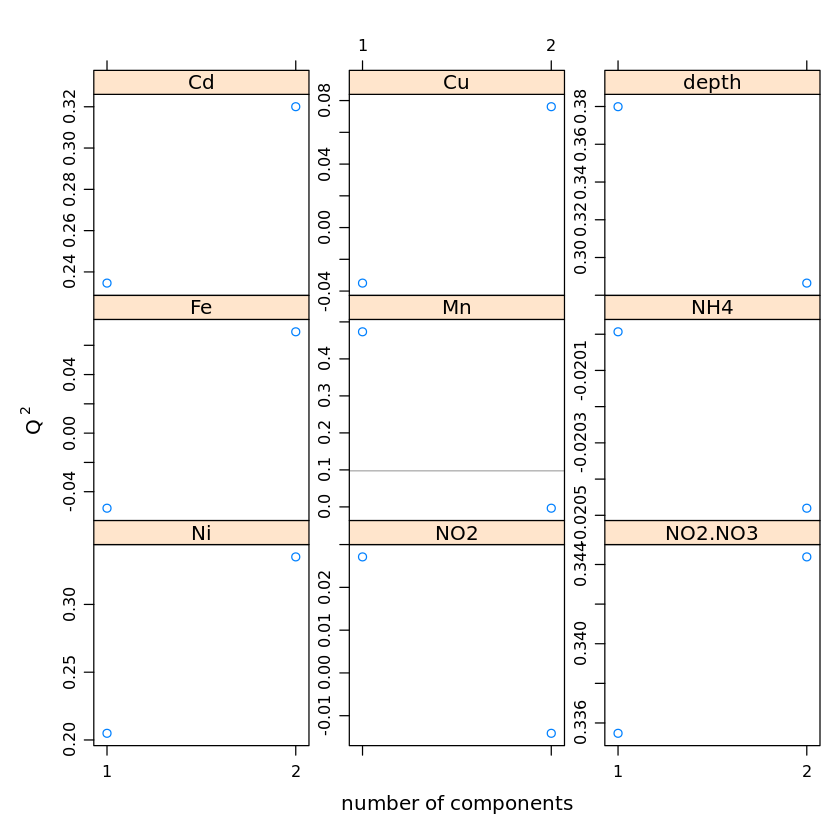

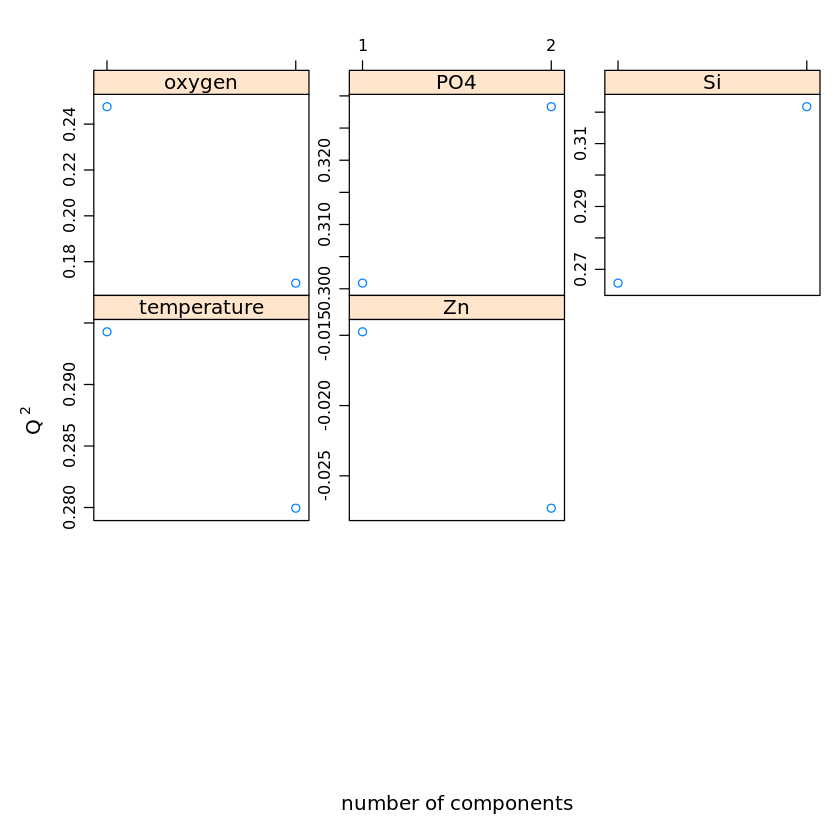

In [39]:
plot(result.val, criterion  = 'Q2')
# try multiple components, here ncomp = 2 is enough

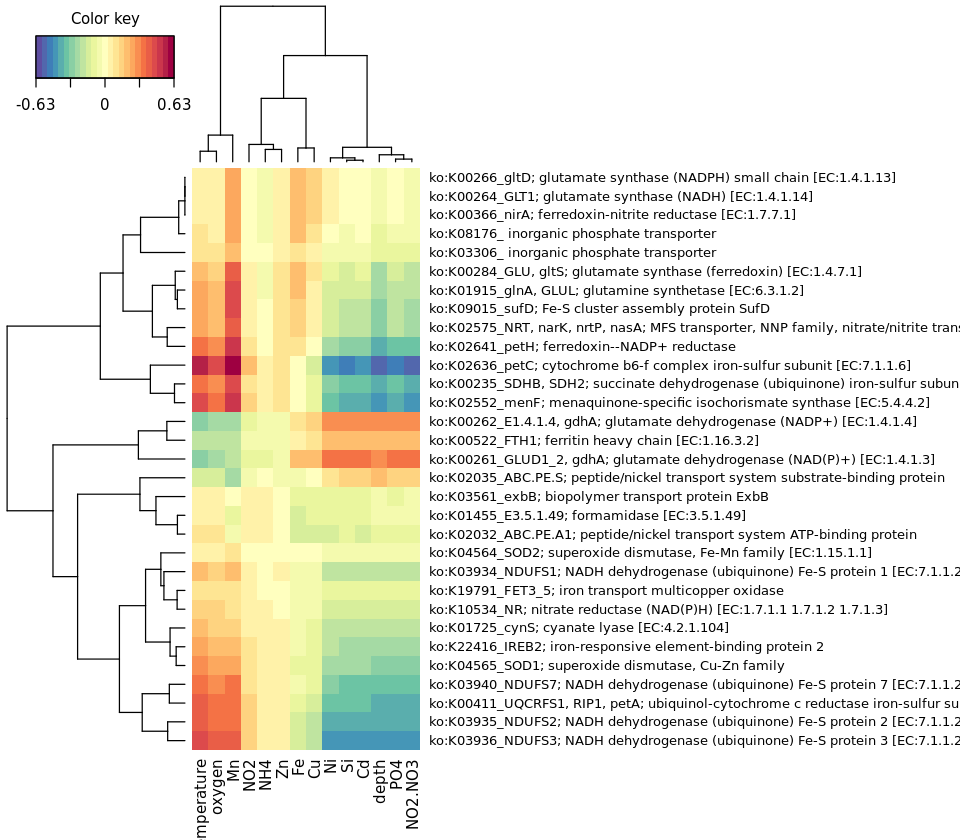

In [40]:
options(repr.plot.width = 8, repr.plot.height = 7)
cim(result, margins = c(5,30))

temperature
ko:K03936_NDUFS3; NADH dehydrogenase (ubiquinone) Fe-S protein 3 [EC:7.1.1.2 1.6.99.3]            0.45369907
ko:K03935_NDUFS2; NADH dehydrogenase (ubiquinone) Fe-S protein 2 [EC:7.1.1.2 1.6.99.3]            0.40357875
ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]  0.38102811
ko:K03940_NDUFS7; NADH dehydrogenase (ubiquinone) Fe-S protein 7 [EC:7.1.1.2 1.6.99.3]            0.35429756
ko:K04565_SOD1; superoxide dismutase, Cu-Zn family                                                0.28165735
ko:K22416_IREB2; iron-responsive element-binding protein 2                                        0.23591999
ko:K01725_cynS; cyanate lyase [EC:4.2.1.104]                                                      0.19823197
ko:K10534_NR; nitrate reductase (NAD(P)H) [EC:1.7.1.1 1.7.1.2 1.7.1.3]                            0.14884762
ko:K19791_FET3_5; iron transport multicopper oxidase                                              0.10518909
ko:K03934_NDUFS1; NADH dehydrogenase (ubiquinone) Fe-S protein 1 [EC:7.1.1.2 1.6.99.3]            0.20092502
ko:K04564_SOD2; superoxide dismutase, Fe-Mn family [EC:1.15.1.1]                                  0.05403191
ko:K02032_ABC.PE.A1; peptide/nickel transport system ATP-binding protein                          0.09412209
ko:K01455_E3.5.1.49; formamidase [EC:3.5.1.49]                                                    0.04813832
ko:K03561_exbB; biopolymer transport protein ExbB                                                 0.06548370
ko:K02035_ABC.PE.S; peptide/nickel transport system substrate-binding protein                    -0.16287768
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                          -0.31816230
ko:K00522_FTH1; ferritin heavy chain [EC:1.16.3.2]                                               -0.20831190
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                           -0.30531957
ko:K02552_menF; menaquinone-specific isochorismate synthase [EC:5.4.4.2]                          0.43144930
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]       0.37086492
ko:K02636_petC; cytochrome b6-f complex iron-sulfur subunit [EC:7.1.1.6]                          0.53706586
ko:K02641_petH; ferredoxin--NADP+ reductase                                                       0.35224670
ko:K02575_NRT, narK, nrtP, nasA; MFS transporter, NNP family, nitrate/nitrite transporter         0.24764826
ko:K09015_sufD; Fe-S cluster assembly protein SufD                                                0.25163865
ko:K01915_glnA, GLUL; glutamine synthetase [EC:6.3.1.2]                                           0.23010809
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                                 0.19204877
ko:K03306_ inorganic phosphate transporter                                                        0.09670915
ko:K08176_ inorganic phosphate transporter                                                        0.07798951
ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]                                         0.03941489
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                           0.03941489
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                              0.03941489
                                                                                                 oxygen     
ko:K03936_NDUFS3; NADH dehydrogenase (ubiquinone) Fe-S protein 3 [EC:7.1.1.2 1.6.99.3]            0.39136663
ko:K03935_NDUFS2; NADH dehydrogenase (ubiquinone) Fe-S protein 2 [EC:7.1.1.2 1.6.99.3]            0.34736113
ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]  0.32924140
ko:K03940_NDUFS7; NADH dehydrogenase (ubiquinone) Fe-S protein 7 [EC:7.1.1.2 1.6.99.3]            0.30691874
ko:K04565_SOD1; superoxide dismutase, Cu-Zn family              

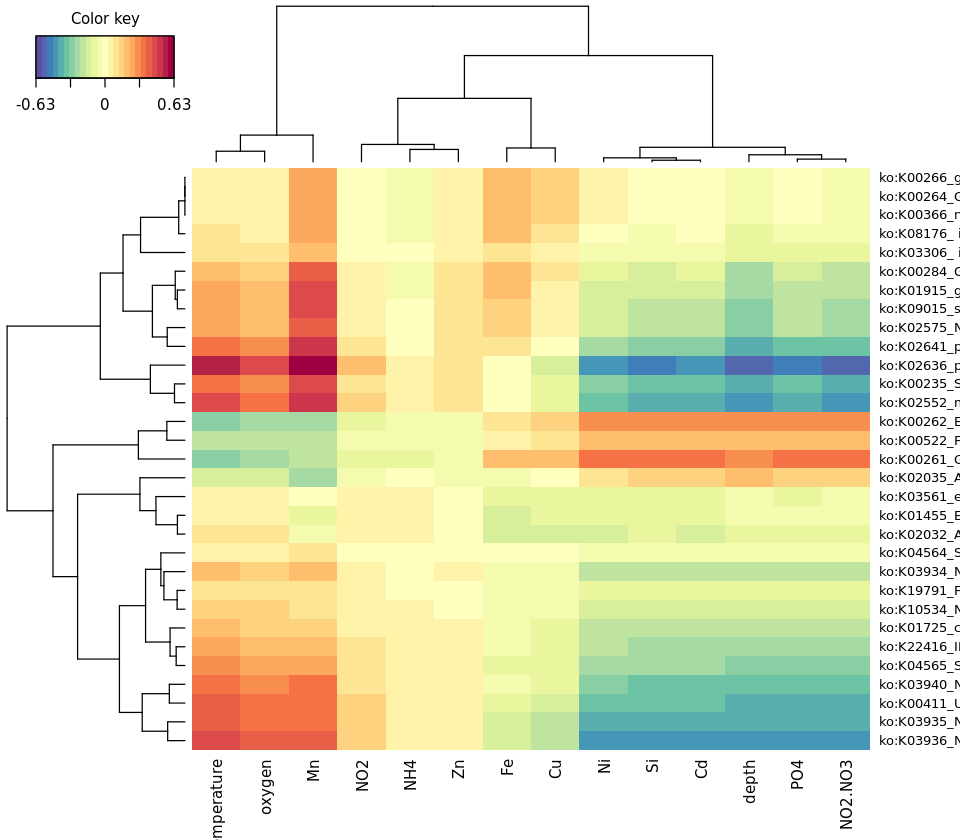

In [41]:
cim<-cim(result)
cim$mat #correlation matrix

In [42]:
cim<-as.data.frame(as.matrix(cim$mat))

In [43]:
cim$KO_def<-rownames(cim)
g<-merge(cim, gois, by='KO_def')
rownames(g)<-g$KO_def

In [44]:
annotation <- data.frame(Class = g$id)
rownames(annotation)<-rownames(g)

In [45]:
g<-g[,-18]
g<-g[,-17]
g<-g[,-16]
g<-g[,-1]
head(g)

temperature
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]  0.37086492
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     -0.31816230
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      -0.30531957
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                      0.03941489
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                         0.03941489
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                            0.19204877
                                                                                            oxygen     
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]  0.32219335
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     -0.27227348
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      -0.26286622
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                      0.03876563
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                         0.03876563
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                            0.17095679
                                                                                            Mn        
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]  0.4286639
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     -0.1922552
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      -0.2517036
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                      0.2375915
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                         0.2375915
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                            0.3965504
                                                                                            NO2         
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]  0.121691293
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     -0.123510093
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      -0.111205183
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     -0.007980324
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                        -0.007980324
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                            0.044004967
                                                                                            NH4        
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]  0.03365381
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     -0.07573497
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      -0.05473042
ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                     -0.04770417
ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                        -0.04770417
ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                           -0.02919026
                                                                                            Zn         
ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]  0.07788948
ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                     -0.02925548
ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                      -0.04246107
ko:K00264_GLT1; glutamate synthase (

In [46]:
options(repr.plot.width = 12, repr.plot.height = 8)

In [47]:
library(viridis)
library(pheatmap)

Loading required package: viridisLite



In [48]:
newCols <- colorRampPalette(grDevices::rainbow(length(unique(annotation$Class))))
mycolors <- newCols(length(unique(annotation$Class)))
names(mycolors) <- unique(annotation$Class)
mycolors <- list(Class = mycolors)
mycolors = list("Class"=c('iron'='#ff855c','nitrogen'='#d199ff','nickel'='#7dfffd','phosphorus'='#a7ff78','carbon'='#ff6bd3','siderophore'='#6b70ff','divalent metal'='#ffe4b5','manganese'='#ff6395','zinc'='#45b8ff','transcription factor'='#92b3a0','copper'='#fff266'))

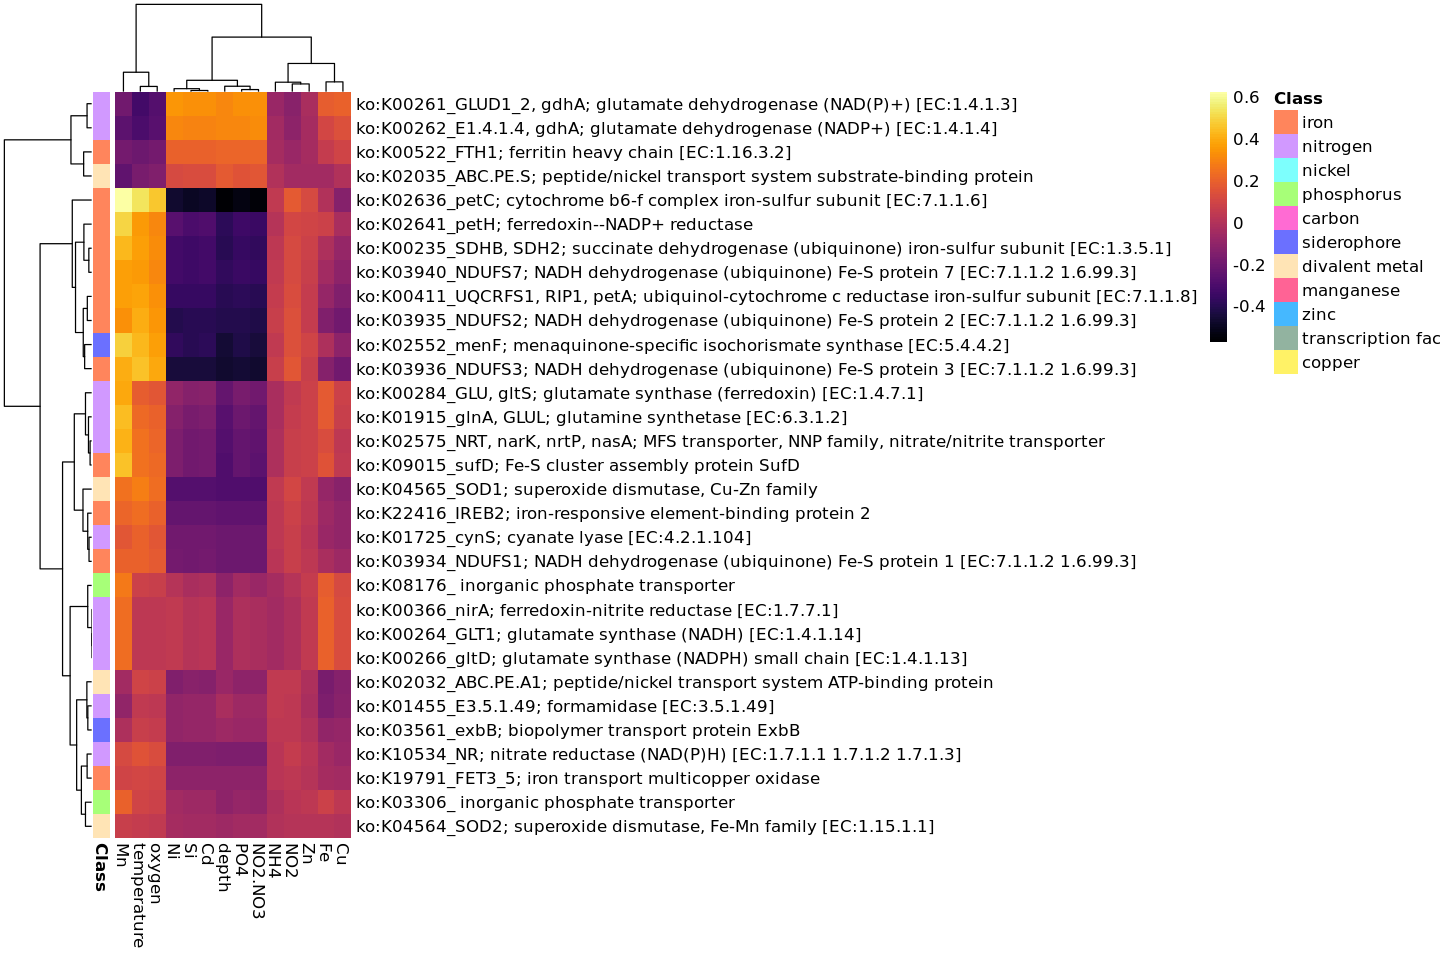

In [49]:
myColor <- viridis_pal(option = "inferno")(100)
plot<-pheatmap(mat = g[,-15], annotation_row = annotation, color = myColor, cluster_rows=T, annotation_colors = mycolors)

In [161]:
ggsave(file="eukprot_pls_proteins_nutrients.eps", plot, dpi = 600, width = 12, height = 4)

In [56]:
#For pulling out individual proteins of interest
Euk<-c('Eukaryota')
sub<-subset1[subset1$domain %in% Euk,]
GOI<-c('ko:K04752','ko:K03594','ko:K02040','ko:K03832','ko:K02014','ko:K01113','ko:K02193','ko:K02364','ko:K02016','ko:K04751','ko:K02013','ko:K03594','ko:K04561','ko:K04755','ko:K04565','ko:K016627','ko:K08176','ko:K19791','ko:K07243','ko:K03306')
#GOI<-c('ko:K03594','ko:K02040')
sub1<-sub[sub$KEGG_ko %in% GOI,]
head(sub1)

transcript_name                   class            KEGG_ko   domain   
1 megahit_HN011_k141_54013.p1        Prasinococcales ko:K02040 Eukaryota
2 megahit_HN012_k141_36464.p1        Dinophyceae     ko:K02040 Eukaryota
3 megahit_HN015_k141_115428.p1       Bacillariophyta ko:K02014 Eukaryota
4 megahit_HN021_k141_57564.p1        Dinophyceae     ko:K02040 Eukaryota
5 transabyss_HN006_.k50R4819259.p1   Prasinococcales ko:K02040 Eukaryota
6 transabyss_HN015_.k110R1005244.p2  Pelagophyceae   ko:K03306 Eukaryota
  division         1_30_0.2 1_115_0.2 1_30_3    1_115_3 1_150 ⋯ 7_300    
1  Chlorophyta     0        0         0.1386285 0       0     ⋯ 0.0000000
2  Dinophyta       0        0         0.0000000 0       0     ⋯ 0.0000000
3  Stramenopiles_X 0        0         0.0000000 0       0     ⋯ 0.1263283
4  Dinophyta       0        0         0.0000000 0       0     ⋯ 0.0000000
5  Chlorophyta     0        0         0.1378785 0       0     ⋯ 0.0000000
6  Stramenopiles_X 0        0         0.0000000 0       0     ⋯ 0.0000000
  8_20       8_40 8_120     8_175      8_400 8_800      8_250      8_600      X
1 0.00000000 0    0.0000000 0.00000000 0     0.00000000 0.00000000 0.00000000 0
2 0.00000000 0    0.0000000 0.00000000 0     0.00000000 0.00000000 0.00000000 0
3 0.01946906 0    0.0318142 0.02896704 0     0.02865526 0.04338542 0.08276417 0
4 0.00000000 0    0.0000000 0.00000000 0     0.00000000 0.00000000 0.00000000 0
5 0.00000000 0    0.0000000 0.00000000 0     0.00000000 0.00000000 0.00000000 0
6 0.00000000 0    0.0000000 0.00000000 0     0.00000000 0.00000000 0.00000000 0

In [57]:
library(caroline)
write.csv(sub1, 'proteins_LCA3%_RefSeq_review.csv')

In [90]:
GOI<-c('ko:K02014','ko:K02040')
sub1<-sub[sub$KEGG_ko %in% GOI,]
head(sub1)

transcript_name              class            KEGG_ko   domain   
1 megahit_HN006_k141_532021.p1  Bacillariophyta ko:K02014 Eukaryota
2 megahit_HN011_k141_187643.p1  Bacillariophyta ko:K02014 Eukaryota
3 megahit_HN011_k141_54013.p1   Prasinococcales ko:K02040 Eukaryota
4 megahit_HN012_k141_36464.p1   Dinophyceae     ko:K02040 Eukaryota
5 megahit_HN015_k141_115428.p1  Bacillariophyta ko:K02014 Eukaryota
6 megahit_HN021_k141_57564.p1   Dinophyceae     ko:K02040 Eukaryota
  division         2_60       2_90      2_120     2_150 3_10       3_20      
1  Stramenopiles_X 0.05084287 0.0000000 0.0000000 0     0.13769419 0.17509197
2  Stramenopiles_X 0.00000000 0.0000000 0.0000000 0     0.04574733 0.02379777
3  Chlorophyta     0.02158156 0.0000000 0.0000000 0     0.00000000 0.04053941
4  Dinophyta       0.02826156 0.0000000 0.0000000 0     0.00000000 0.00000000
5  Stramenopiles_X 0.00000000 0.0149068 0.0165628 0     0.00000000 0.00000000
6  Dinophyta       0.00000000 0.0000000 0.0000000 0     0.00000000 0.00000000
  3_30       3_45       3_60      3_75       3_90       3_105      3_120    
1 0.12046107 0.16112925 0.1404403 0.06605044 0.08844316 0.00000000 0.0000000
2 0.02572831 0.02409001 0.0000000 0.00000000 0.00000000 0.00000000 0.0000000
3 0.04382809 0.02735817 0.0000000 0.00000000 0.00000000 0.00000000 0.0000000
4 0.00000000 0.00000000 0.1040870 0.00000000 0.00000000 0.00000000 0.0000000
5 0.02231986 0.02089860 0.0000000 0.02141700 0.01911859 0.03649207 0.0414806
6 0.00000000 0.00000000 0.0000000 0.00000000 0.15165253 0.00000000 0.0000000
  3_150     3_200     3_400     3_600      3_1000     3_1200     7_20     
1 0.0000000 0.0000000 0.0000000 0.00000000 0.00000000 0.00000000 0.1154739
2 0.0000000 0.0000000 0.0000000 0.00000000 0.00000000 0.00000000 0.0000000
3 0.0000000 0.0000000 0.0000000 0.00000000 0.00000000 0.00000000 0.0000000
4 0.0000000 0.0000000 0.0000000 0.00000000 0.00000000 0.00000000 0.0000000
5 0.0262021 0.1293199 0.1409067 0.03411858 0.06935549 0.03442248 0.0000000
6 0.0000000 0.0000000 0.0000000 0.00000000 0.00000000 0.00000000 0.0000000
  7_40     7_70       7_108 7_112_A 7_112_B 7_117 7_122     7_700     
1 0.140754 0.13055377 0     0       0       0     0.0000000 0.00000000
2 0.000000 0.00000000 0     0       0       0     0.0000000 0.00000000
3 0.000000 0.02216675 0     0       0       0     0.0000000 0.00000000
4 0.000000 0.00000000 0     0       0       0     0.0000000 0.00000000
5 0.000000 0.00000000 0     0       0       0     0.1377299 0.05775505
6 0.000000 0.00000000 0     0       0       0     0.0000000 0.00000000
  8_20       8_40 8_120      8_175      8_400 8_800      X
1 0.04095103 0    0.00000000 0.00000000 0     0.00000000 0
2 0.00000000 0    0.00000000 0.00000000 0     0.00000000 0
3 0.00000000 0    0.00000000 0.00000000 0     0.00000000 0
4 0.00000000 0    0.00000000 0.00000000 0     0.00000000 0
5 0.01770461 0    0.02927714 0.02661022 0     0.02645103 0
6 0.00000000 0    0.00000000 0.00000000 0     0.00000000 0

# Transcripts and proteins correlation

In [587]:
#tr<-read.csv('transcripts.goi.pls.csv') #read in TPM transcripts collapsed at the target KEGG genes level 
tr<-read.csv('transcripts.goi.pls_split.csv') # target KEGG genes level (split NOT summed), makes little difference in final plot

In [588]:
rownames(tr)<-tr$X
tr<-tr[,-1]

In [589]:
colnames(tr)<-gsub('X','',colnames(tr))
tr$def<-rownames(tr)

In [590]:
tr.t<-t(tr)
tr.t<-as.data.frame(tr.t)

In [591]:
t.e<-t(e)
t.e<-as.data.frame(t.e) #proteins from above

In [592]:
colnames(tr.t)<-paste('TRANS',colnames(tr.t),sep='_')
tr.t$ID<-rownames(tr.t)
colnames(t.e)<-paste('PROT',colnames(t.e),sep='_')
t.e$ID<-rownames(t.e)

In [593]:
#tr.t<-tr.t[-85,]
#t.e<-t.e[-31,]
t.e<-t.e[, colSums(t.e != 0) > 0] #remove columns that sum to 0
t.e<-t.e[apply(t.e[,-1], 1, function(x) !all(x==0)),] #remove rows that sum to 0
tr.t<-tr.t[, colSums(t.e != 0) > 0] #remove columns that sum to 0
tr.t<-tr.t[apply(tr.t[,-1], 1, function(x) !all(x==0)),] #remove rows that sum to 0

In [594]:
f<-merge(tr.t, t.e, by='ID')

In [595]:
rownames(f)<-f$ID
f<-f[,-1]

In [596]:
f<-f %>% mutate_if(is.character,as.numeric)

In [632]:
head(Y)

PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]
1_115_0.2 0.00000000                                                                                      
1_115_3   0.03394501                                                                                      
1_200     0.00000000                                                                                      
1_30_0.2  0.00000000                                                                                      
1_30_3    0.02117935                                                                                      
1_400     0.00000000                                                                                      
          PROT_ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]
1_115_0.2 0.00000000                                                                  
1_115_3   0.01730887                                                                  
1_200     0.00000000                                                                  
1_30_0.2  0.00000000                                                                  
1_30_3    0.00000000                                                                  
1_400     0.00000000                                                                  
          PROT_ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]
1_115_0.2 0                                                                          
1_115_3   0                                                                          
1_200     0                                                                          
1_30_0.2  0                                                                          
1_30_3    0                                                                          
1_400     0                                                                          
          PROT_ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
1_115_0.2 0                                                                     
1_115_3   0                                                                     
1_200     0                                                                     
1_30_0.2  0                                                                     
1_30_3    0                                                                     
1_400     0                                                                     
          PROT_ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]
1_115_0.2 0                                                             
1_115_3   0                                                             
1_200     0                                                             
1_30_0.2  0                                                             
1_30_3    0                                                             
1_400     0                                                             
          PROT_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]
1_115_0.2 0                                                                                                    
1_115_3   0                                                                                                    
1_200     0                                                                                                    
1_30_0.2  0                                                                                                    
1_30_3    0                                                                                                    
1_400     0                                                                                                    
          PROT_ko:K00459_ncd2, npd; nitronate monooxygenase [EC:1.13.12.16]
1_115_0.2 0                                                                
1_115_3   0                         

In [606]:
X = f[1:77]
Y = f[78:111]

In [609]:
X<-X[,-28] #remove K02014
#X<-X[,-31] #remove PSTS

In [610]:
library(mixOmics)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice


Loaded mixOmics 6.13.114
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')



Attaching package: ‘mixOmics’


The following object is masked from ‘package:psych’:

    pca




In [611]:
result <- pls(X, Y, ncomp = 2, mode = "regression")

Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”


In [612]:
result


Call:
 pls(X = X, Y = Y, ncomp = 2, mode = "regression") 

 PLS with a 'regression' mode with 2 PLS components. 
 You entered data X of dimensions: 43 76 
 You entered data Y of dimensions: 43 34 

 No variable selection. 

 Main numerical outputs: 
 -------------------- 
 loading vectors: see object$loadings 
 variates: see object$variates 
 variable names: see object$names 

 Functions to visualise samples: 
 -------------------- 
 plotIndiv, plotArrow 

 Functions to visualise variables: 
 -------------------- 
 plotVar, plotLoadings, network, cim 

In [613]:
result.val <- perf(result, validation = "loo")
#plot(result.val, criterion  = 'Q2')
result.val$MSEP

Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Warning message 

1 comp   
PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]      0.7327472
PROT_ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                          1.0544210
PROT_ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                           1.0311193
PROT_ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                                1.1308594
PROT_ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]                                        1.0333330
PROT_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8] 1.0438066
PROT_ko:K00459_ncd2, npd; nitronate monooxygenase [EC:1.13.12.16]                                     0.0000000
PROT_ko:K00522_FTH1; ferritin heavy chain [EC:1.16.3.2]                                               1.0266831
PROT_ko:K01455_E3.5.1.49; formamidase [EC:3.5.1.49]                                                   1.0464988
PROT_ko:K01725_cynS; cyanate lyase [EC:4.2.1.104]                                                     1.0735204
PROT_ko:K01915_glnA, GLUL; glutamine synthetase [EC:6.3.1.2]                                          1.0203228
PROT_ko:K02014_TC.FEV.OM; iron complex outermembrane recepter protein                                 0.7747922
PROT_ko:K02032_ABC.PE.A1; peptide/nickel transport system ATP-binding protein                         1.0477245
PROT_ko:K02035_ABC.PE.S; peptide/nickel transport system substrate-binding protein                    0.9800816
PROT_ko:K02040_pstS; phosphate transport system substrate-binding protein                             1.0525678
PROT_ko:K02552_menF; menaquinone-specific isochorismate synthase [EC:5.4.4.2]                         0.9617694
PROT_ko:K02575_NRT, narK, nrtP, nasA; MFS transporter, NNP family, nitrate/nitrite transporter        1.0522468
PROT_ko:K02636_petC; cytochrome b6-f complex iron-sulfur subunit [EC:7.1.1.6]                         0.8418392
PROT_ko:K02641_petH; ferredoxin--NADP+ reductase                                                      0.9897248
PROT_ko:K03306_ inorganic phosphate transporter                                                       1.0364591
PROT_ko:K03561_exbB; biopolymer transport protein ExbB                                                1.0402408
PROT_ko:K03809_wrbA; NAD(P)H dehydrogenase (quinone) [EC:1.6.5.2]                                     1.0301414
PROT_ko:K03934_NDUFS1; NADH dehydrogenase (ubiquinone) Fe-S protein 1 [EC:7.1.1.2 1.6.99.3]           1.0962098
PROT_ko:K03935_NDUFS2; NADH dehydrogenase (ubiquinone) Fe-S protein 2 [EC:7.1.1.2 1.6.99.3]           1.0244895
PROT_ko:K03936_NDUFS3; NADH dehydrogenase (ubiquinone) Fe-S protein 3 [EC:7.1.1.2 1.6.99.3]           0.8075032
PROT_ko:K03940_NDUFS7; NADH dehydrogenase (ubiquinone) Fe-S protein 7 [EC:7.1.1.2 1.6.99.3]           0.9448051
PROT_ko:K03941_NDUFS8; NADH dehydrogenase (ubiquinone) Fe-S protein 8 [EC:7.1.1.2 1.6.99.3]           1.3516689
PROT_ko:K04564_SOD2; superoxide dismutase, Fe-Mn family [EC:1.15.1.1]                                 1.0321499
PROT_ko:K04565_SOD1; superoxide dismutase, Cu-Zn family                                               1.0463376
PROT_ko:K07243_FTR, FTH1, efeU; high-affinity iron transporter                                        0.0000000
PROT_ko:K08176_ inorganic phosphate transporter                                                       1.0386487
PROT_ko:K09013_sufC; Fe-S cluster assembly ATP-binding protein                                        0.0000000
PROT_ko:K09015_sufD; Fe-S cluster assembly protein SufD                                               1.0679783
PROT_ko:K19791_FET3_5; iron transport multicopper oxidase                                             1.0250782
                                                                                                      2 comp   
PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-s

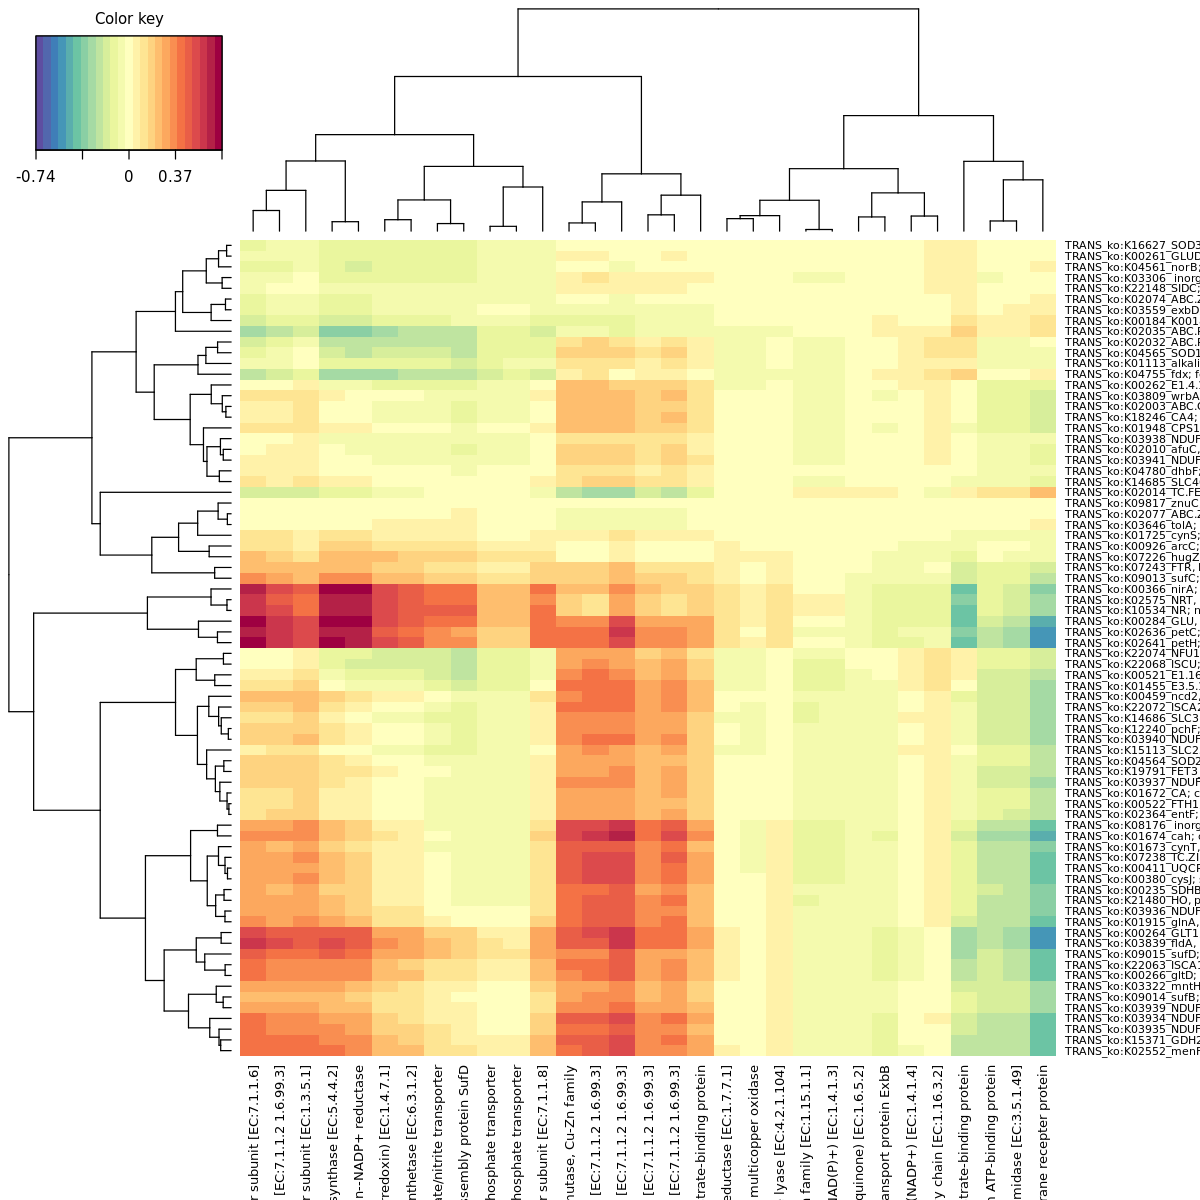

In [614]:
options(repr.plot.width = 10, repr.plot.height = 10)
cim(result, margins = c(8,8))

PROT_ko:K02636_petC; cytochrome b6-f complex iron-sulfur subunit [EC:7.1.1.6]
TRANS_ko:K02552_menF; menaquinone-specific isochorismate synthase [EC:5.4.4.2]                                  0.43911655                                                                   
TRANS_ko:K15371_GDH2; glutamate dehydrogenase [EC:1.4.1.2]                                                      0.43076217                                                                   
TRANS_ko:K03935_NDUFS2; NADH dehydrogenase (ubiquinone) Fe-S protein 2 [EC:7.1.1.2 1.6.99.3]                    0.38687320                                                                   
TRANS_ko:K03934_NDUFS1; NADH dehydrogenase (ubiquinone) Fe-S protein 1 [EC:7.1.1.2 1.6.99.3]                    0.39074958                                                                   
TRANS_ko:K03939_NDUFS6; NADH dehydrogenase (ubiquinone) Fe-S protein 6                                          0.29408330                                                                   
TRANS_ko:K09014_sufB; Fe-S cluster assembly protein SufB                                                        0.25947159                                                                   
TRANS_ko:K03322_mntH; manganese transport protein                                                               0.30750245                                                                   
TRANS_ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                                      0.41526118                                                                   
TRANS_ko:K22063_ISCA1; iron-sulfur cluster assembly 1                                                           0.40691023                                                                   
TRANS_ko:K09015_sufD; Fe-S cluster assembly protein SufD                                                        0.48434527                                                                   
TRANS_ko:K03839_fldA, nifF, isiB; flavodoxin I                                                                  0.56363104                                                                   
TRANS_ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                                   0.53713152                                                                   
TRANS_ko:K01915_glnA, GLUL; glutamine synthetase [EC:6.3.1.2]                                                   0.34119692                                                                   
TRANS_ko:K03936_NDUFS3; NADH dehydrogenase (ubiquinone) Fe-S protein 3 [EC:7.1.1.2 1.6.99.3]                    0.31369289                                                                   
TRANS_ko:K21480_HO, pbsA1, hmuO; heme oxygenase (biliverdin-producing, ferredoxin) [EC:1.14.15.20]              0.29175807                                                                   
TRANS_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]               0.27130819                                                                   
TRANS_ko:K00380_cysJ; sulfite reductase (NADPH) flavoprotein alpha-component [EC:1.8.1.2]                       0.31543093                                                                   
TRANS_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]          0.30210163                                                                   
TRANS_ko:K07238_TC.ZIP, zupT, ZRT3, ZIP2; zinc transporter, ZIP family                                          0.31507438                                                                   
TRANS_ko:K01673_cynT, can; carbonic anhydrase [EC:4.2.1.1]                                                      0.26719751                                                                   
TRANS_ko:K01674_cah; carbonic anhydrase [EC:4.2.1.1]                                                            0.35846189

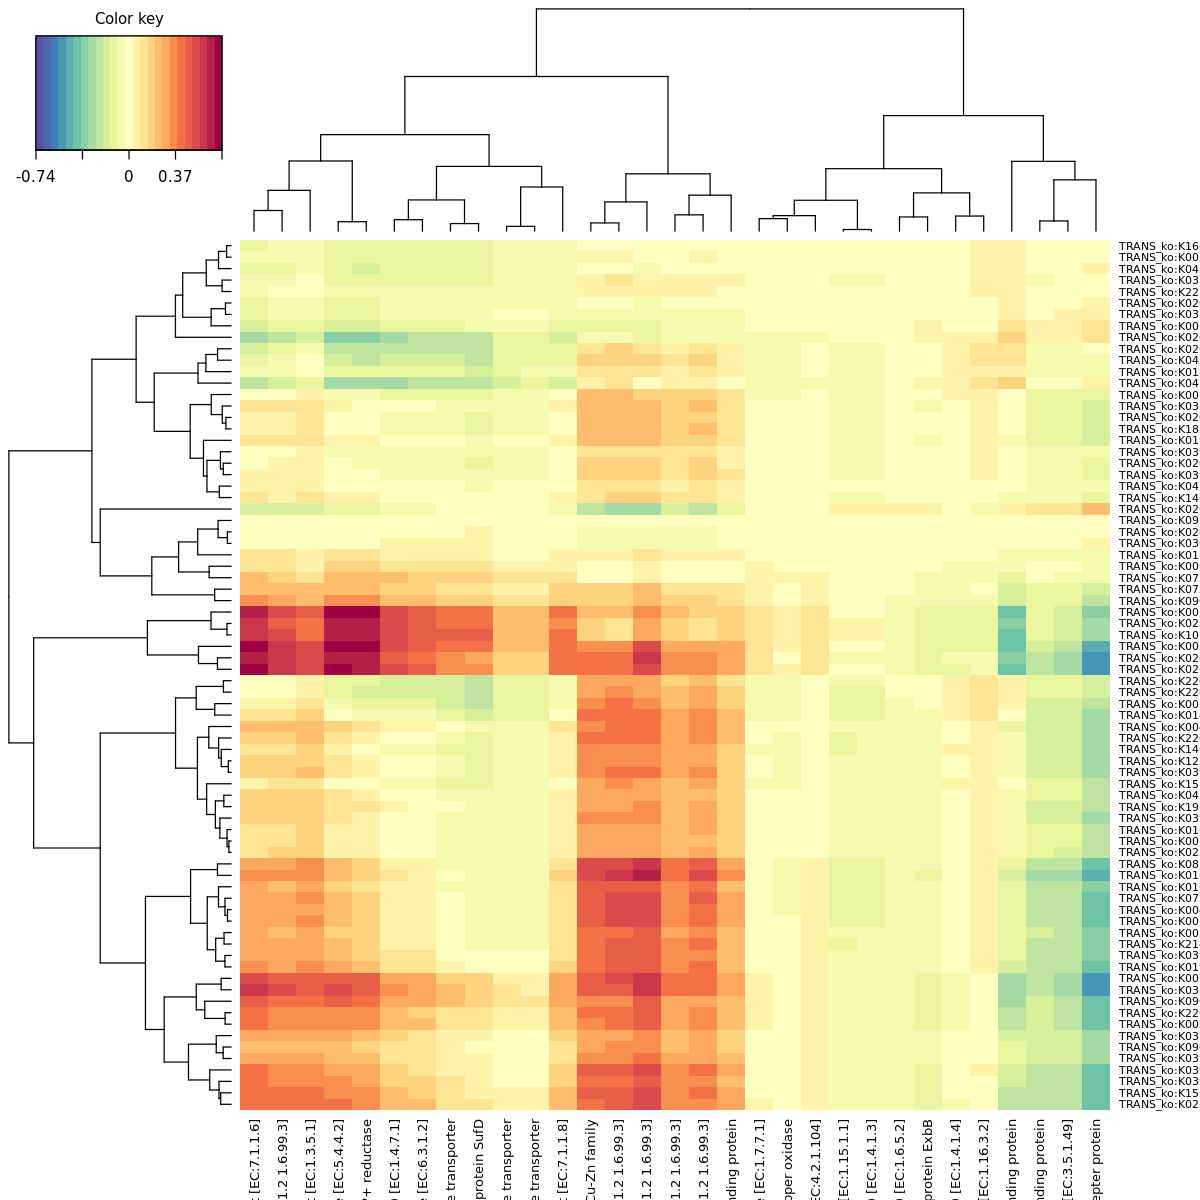

In [615]:
cim<-cim(result)
cim$mat 

In [616]:
cim<-as.data.frame(as.matrix(cim$mat))
cim$KO_def<-rownames(cim)
#g<-merge(cim, gois, by='KO_def')
#rownames(g)<-g$KO_def

In [617]:
cim

PROT_ko:K02636_petC; cytochrome b6-f complex iron-sulfur subunit [EC:7.1.1.6]
TRANS_ko:K02552_menF; menaquinone-specific isochorismate synthase [EC:5.4.4.2]                                  0.43911655                                                                   
TRANS_ko:K15371_GDH2; glutamate dehydrogenase [EC:1.4.1.2]                                                      0.43076217                                                                   
TRANS_ko:K03935_NDUFS2; NADH dehydrogenase (ubiquinone) Fe-S protein 2 [EC:7.1.1.2 1.6.99.3]                    0.38687320                                                                   
TRANS_ko:K03934_NDUFS1; NADH dehydrogenase (ubiquinone) Fe-S protein 1 [EC:7.1.1.2 1.6.99.3]                    0.39074958                                                                   
TRANS_ko:K03939_NDUFS6; NADH dehydrogenase (ubiquinone) Fe-S protein 6                                          0.29408330                                                                   
TRANS_ko:K09014_sufB; Fe-S cluster assembly protein SufB                                                        0.25947159                                                                   
TRANS_ko:K03322_mntH; manganese transport protein                                                               0.30750245                                                                   
TRANS_ko:K00266_gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]                                      0.41526118                                                                   
TRANS_ko:K22063_ISCA1; iron-sulfur cluster assembly 1                                                           0.40691023                                                                   
TRANS_ko:K09015_sufD; Fe-S cluster assembly protein SufD                                                        0.48434527                                                                   
TRANS_ko:K03839_fldA, nifF, isiB; flavodoxin I                                                                  0.56363104                                                                   
TRANS_ko:K00264_GLT1; glutamate synthase (NADH) [EC:1.4.1.14]                                                   0.53713152                                                                   
TRANS_ko:K01915_glnA, GLUL; glutamine synthetase [EC:6.3.1.2]                                                   0.34119692                                                                   
TRANS_ko:K03936_NDUFS3; NADH dehydrogenase (ubiquinone) Fe-S protein 3 [EC:7.1.1.2 1.6.99.3]                    0.31369289                                                                   
TRANS_ko:K21480_HO, pbsA1, hmuO; heme oxygenase (biliverdin-producing, ferredoxin) [EC:1.14.15.20]              0.29175807                                                                   
TRANS_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]               0.27130819                                                                   
TRANS_ko:K00380_cysJ; sulfite reductase (NADPH) flavoprotein alpha-component [EC:1.8.1.2]                       0.31543093                                                                   
TRANS_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]          0.30210163                                                                   
TRANS_ko:K07238_TC.ZIP, zupT, ZRT3, ZIP2; zinc transporter, ZIP family                                          0.31507438                                                                   
TRANS_ko:K01673_cynT, can; carbonic anhydrase [EC:4.2.1.1]                                                      0.26719751                                                                   
TRANS_ko:K01674_cah; carbonic anhydrase [EC:4.2.1.1]                                                            0.35846189

In [618]:
cim<-cim[,-32]

In [619]:
library(viridis)
library(pheatmap)
options(repr.plot.width = 15, repr.plot.height = 25)

Loading required package: viridisLite



In [620]:
annot<-as.data.frame(colnames(cim))
colnames(annot)<-c('KO_def')
annot$original<-annot$KO_def
annot$KO_def<-gsub('PROT_','',annot$KO_def)
head(annot)

KO_def                                                                                     
1 ko:K02636_petC; cytochrome b6-f complex iron-sulfur subunit [EC:7.1.1.6]                   
2 ko:K03940_NDUFS7; NADH dehydrogenase (ubiquinone) Fe-S protein 7 [EC:7.1.1.2 1.6.99.3]     
3 ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]
4 ko:K02552_menF; menaquinone-specific isochorismate synthase [EC:5.4.4.2]                   
5 ko:K02641_petH; ferredoxin--NADP+ reductase                                                
6 ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                          
  original                                                                                        
1 PROT_ko:K02636_petC; cytochrome b6-f complex iron-sulfur subunit [EC:7.1.1.6]                   
2 PROT_ko:K03940_NDUFS7; NADH dehydrogenase (ubiquinone) Fe-S protein 7 [EC:7.1.1.2 1.6.99.3]     
3 PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]
4 PROT_ko:K02552_menF; menaquinone-specific isochorismate synthase [EC:5.4.4.2]                   
5 PROT_ko:K02641_petH; ferredoxin--NADP+ reductase                                                
6 PROT_ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]

In [621]:
annot.t<-as.data.frame(rownames(cim))
colnames(annot.t)<-c('KO_def')
annot.t$original<-annot.t$KO_def
annot.t$KO_def<-gsub('TRANS_','',annot.t$KO_def)

In [622]:
prot<-merge(gois, annot,by='KO_def')
prot<-prot[,3:5]
rownames(prot)<-prot$original
prot<-as.data.frame(prot)
colnames(prot)<-c('def','Class','original')
head(prot)

def                                                                                   
PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]      SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]     
PROT_ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                          GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                         
PROT_ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                           E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                          
PROT_ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                                GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                               
PROT_ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]                                        nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]                                       
PROT_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8] UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]
                                                                                                      Class   
PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]      iron    
PROT_ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                          nitrogen
PROT_ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                           nitrogen
PROT_ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                                nitrogen
PROT_ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]                                        nitrogen
PROT_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8] iron    
                                                                                                      original                                                                                             
PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]      PROT_ko:K00235_SDHB, SDH2; succinate dehydrogenase (ubiquinone) iron-sulfur subunit [EC:1.3.5.1]     
PROT_ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                          PROT_ko:K00261_GLUD1_2, gdhA; glutamate dehydrogenase (NAD(P)+) [EC:1.4.1.3]                         
PROT_ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                           PROT_ko:K00262_E1.4.1.4, gdhA; glutamate dehydrogenase (NADP+) [EC:1.4.1.4]                          
PROT_ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                                PROT_ko:K00284_GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]                               
PROT_ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]                                        PROT_ko:K00366_nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]                                       
PROT_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8] PROT_ko:K00411_UQCRFS1, RIP1, petA; ubiquinol-cytochrome c reductase iron-sulfur subunit [EC:7.1.1.8]

In [623]:
trans<-merge(gois, annot.t,by='KO_def')
trans<-trans[,3:5]
rownames(trans)<-trans$original
trans<-as.data.frame(trans)
colnames(trans)<-c('def','Class','original')

In [624]:
annotation.t <- data.frame(Class = trans$Class)
rownames(annotation.t)<-trans$original
newCols <- colorRampPalette(grDevices::rainbow(length(unique(annotation.t$Class))))
mycolors <- newCols(length(unique(annotation.t$Class)))
names(mycolors) <- unique(annotation.t$Class)


annotation <- data.frame(Class = prot$Class)
rownames(annotation)<-prot$original
newCols <- colorRampPalette(grDevices::rainbow(length(unique(annotation$Class))))
mycolors <- newCols(length(unique(annotation$Class)))
names(mycolors) <- unique(annotation$Class)
#mycolors <- list(Class = mycolors)
mycolors = list("Class"=c('iron'='#ff855c','nitrogen'='#d199ff','nickel'='#7dfffd','phosphorus'='#a7ff78','carbon'='#ff6bd3','siderophore'='#6b70ff','divalent metal'='#ffe4b5','manganese'='#ff6395','zinc'='#45b8ff','transcription factor'='#92b3a0','copper'='#fff266'))

In [625]:
options(repr.plot.width = 18, repr.plot.height = 24)

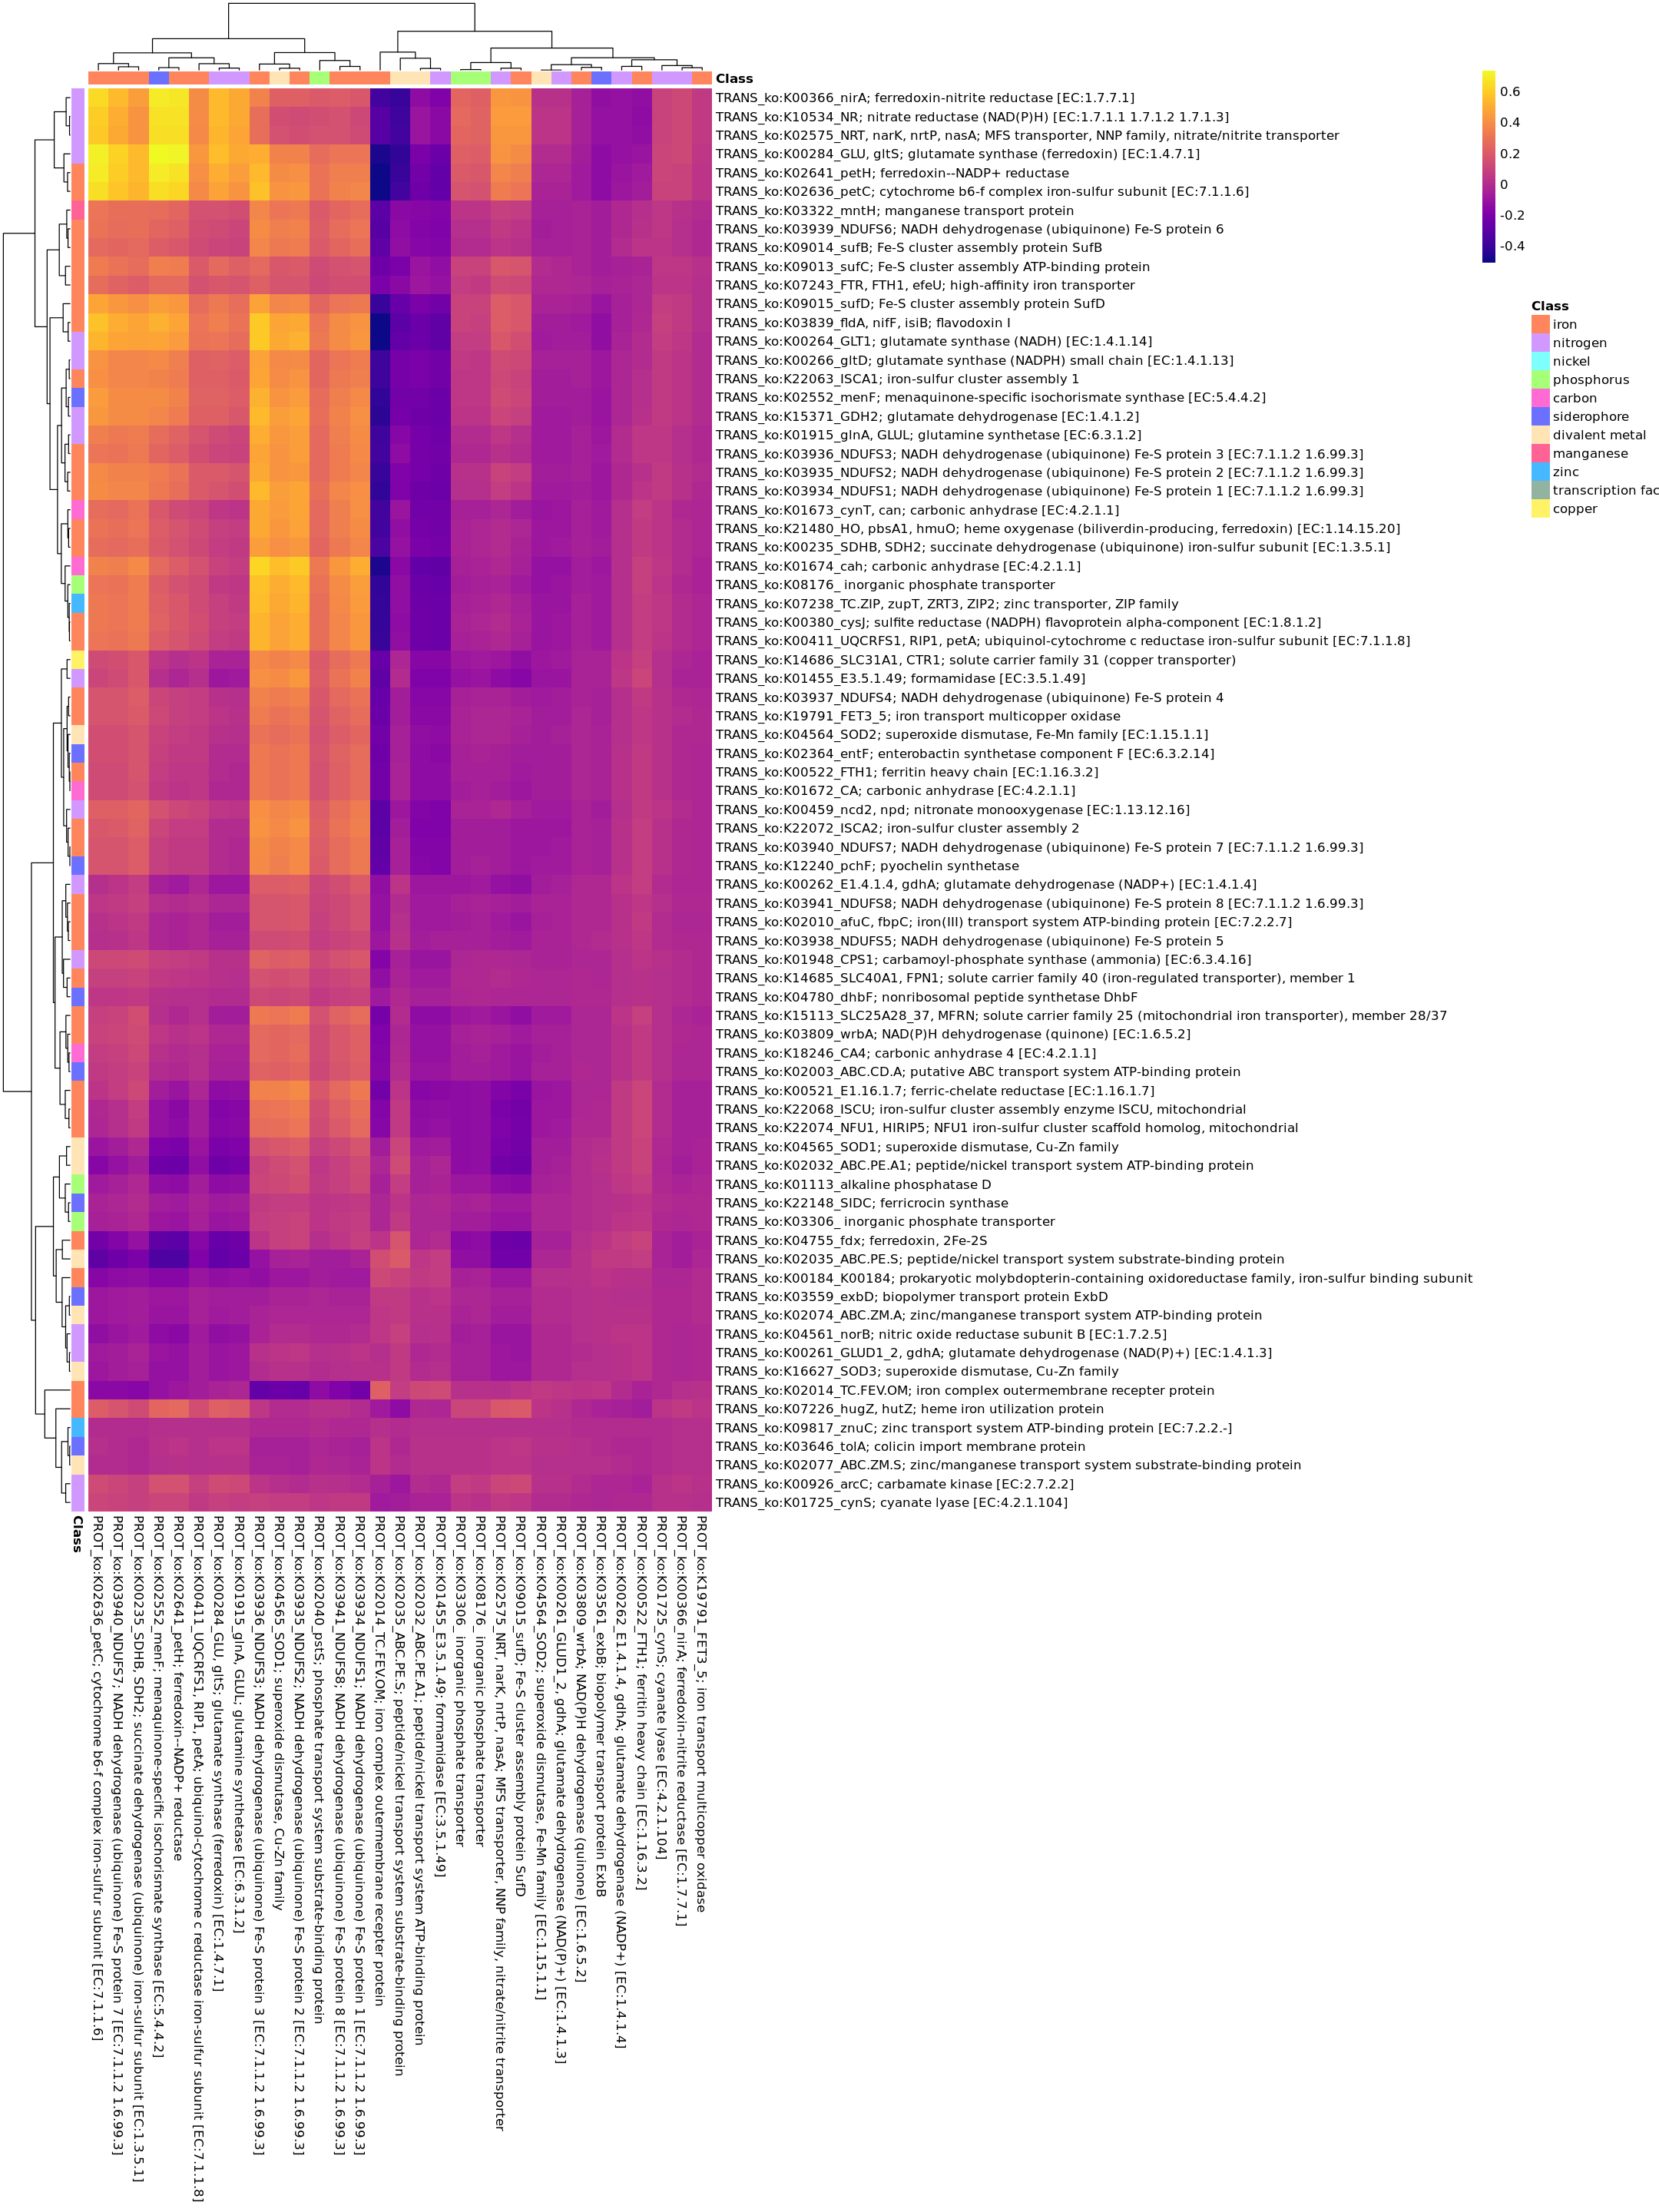

In [626]:
myColor <- viridis_pal(option = "plasma")(100)
plot<-pheatmap(mat = cim, annotation_col = annotation, annotation_row = annotation.t, color = myColor, cluster_rows=T, annotation_colors = mycolors)

In [82]:
ggsave(file="eukprot_pls_cds_prot.eps", plot, dpi = 600, width = 18, height = 24)